# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain
Thesis aiming to evaluate the application of decision tree and random forest classifiers within the financial domain.

This notebook contains 7 sections, where sections 0 to 5 contain function definitions and section 6 contains scripts that execute these functions to get thesis results. To reproduce results, all cells in sections 0 to 5 have to be run first, and then cells in section 6 can be run to reproduce the results.
## Table of Contents
0. Preparation
1. Data Preparation
2. Hyperparameter Tuning
3. Performance Evaluation
4. Visualisation
5. Thesis Evaluation
6. Reproducing Thesis Results

# 0 | Preparation
- Import libraries and define constant variables

### Imports

In [26]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, TimeSeriesSplit, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Plottig
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
params = {'legend.fontsize': '16',
          'figure.figsize': (15, 5),
         'axes.labelsize': '20',
         'axes.titlesize':'20', #'axes.titlesize':'x-large',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
matplotlib.rcParams.update(params)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
from IPython.display import display
import plotly.graph_objects as go

### Constant variables

In [27]:
# Define filenames for technology stock .CSV datasets
AAPL_DATA = "../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
AMZN_DATA = "../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv"
CSCO_DATA = "../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv"
GE_DATA = "../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv"
GOOGL_DATA = "../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"
HP_DATA = "../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv"
IBM_DATA = "../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv"
INTC_DATA = "../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv"
MSFT_DATA = "../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
WU_DATA = "../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv"
XRX_DATA = "../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv"

TECH_GROUP = [AAPL_DATA, AMZN_DATA, CSCO_DATA, GE_DATA, GOOGL_DATA, HP_DATA, IBM_DATA, INTC_DATA, MSFT_DATA, WU_DATA, XRX_DATA]

# Define time horizons to compare classification results for 1-day to 1-year predictions (approx. trading days)
TIME_HORIZONS = [1, 5, 10, 20, 65, 250]

# Make code reproducible by seeding random states
RANDOM_SEED = 42

# Define verbosity
VERBOSE = False

# Centrally define if figures should be saved to ./plots/
SAVE_FIG = False

# 1 | Data Preparation
- Load data and adjust columns as needed, extract features for technical analysis, define classes, detect anomalies
- No feature selection needed as it is embedded in Decision Trees (DT) and Random Forests (RF)
- These functions will later be invoked in the Thesis Evaluation stage

## 1.1 | Load Datasets
- For an apples-to-apples comparison, technology companies are analyzed (idea: companies/stocks within an industry have similar drivers)
- Selected stocks differ in price trends (upward- vs constant- vs downward trend)

In [112]:
def load_OHLC_data(filename=MSFT_DATA, time_horizons=TIME_HORIZONS):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns a corresponding DataFrame.
    Unnecessary categorical columns are dropped, and necessary columns (e.g. month as number) are added.
    """
    try:
        df = pd.read_csv(filename)
        
#         # Visualize loaded time series data and plot, if applicable
#         df["date"] = pd.to_datetime(df["date"])
#         df.plot(x="date", y="close", figsize=(12,6), legend=None, linewidth=3, label=df["Name"][0])
#         plt.xlabel("Zeit [Tagesbasis]")
#         plt.ylabel("Aktienkurs [täglicher Schlusswert in USD]")
#         plt.title(df["Name"][0] + "-Aktienkursentwicklung vom 08.02.2013 bis zum 07.02.2018");
#         fig = plt.gcf()
#         fig.set_size_inches(14, 8)
#         plt.legend(ncol=1)
#         plt.tight_layout()
        
#         plt.savefig("./Plots/Stock-Price-Plots/" + df["Name"][0] + "-Stock-Price-Plot.jpeg")
#         plt.close()
        
        # Calculate base column for later class: future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
        for horizon in time_horizons:
            df["return_future_" + str(horizon) + "d"] = (df["close"].shift(-1*horizon)/df["close"])-1
        
        # Convert date to numerical month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        if VERBOSE is True:
            print("load_OHLC_data() -> Loaded DataFrame has the following columns:")
            for col in df:
                print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
            print("load_OHLC_data() -> df.head():")
            print(df.head())
            
        return df
    except:
        print("load_OHLC_data() -> Error, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with OHLC stock data")

In [113]:
# dfs_TECH_GROUP = []
# for stock in TECH_GROUP:
#     dfs_TECH_GROUP.append(load_OHLC_data(stock))

### Generate Plotly candlestick charts

In [30]:
# df = load_OHLC_data(filename=XRX_DATA, time_horizons=TIME_HORIZONS)

# # Visualize stock data in candlestick chart
# fig = plt.figure()
# fig = go.Figure(data=[go.Candlestick(x=df["date"],open=df["open"], high=df["high"], low=df["low"], close=df["close"])])

# fig.update_layout(
#     title=df["Name"][0] + "-Candlestick Chart auf Tagesbasis von 2013 bis 2018",
#     yaxis_title="Aktienkurs [USD]",
#     xaxis_title="Zeit [Tagesbasis]",
#     xaxis_rangeslider_visible=False
# )

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated and added as features
- Suitable TA libary for more technical features: https://github.com/bukosabino/ta

In [31]:
def extract_OHLC_features(df, time_horizons=TIME_HORIZONS):
    """
    Extract common technical stock analysis features from given OHLC stock data for distinct time horizons
    """
    # Calculate technical features for each time horizon
    for horizon in time_horizons:
        if horizon == 1:
            # Past return of stock over given time horizon (e.g. last week's Monday to this week's Monday)
            df["return_past_" + str(horizon) + "d"] = (df["close"]/df["close"].shift(2))-1
            # Implied volatility measured by standard deviation
            df["volatility_" + str(horizon) + "d"] = df["close"].rolling(2).std()
            # Moving averages (ma)
            df["ma_" + str(horizon) + "d"] = df["close"].rolling(2).mean()
            # Momentum (absolute change in price over past horizon)
            df["momentum_" + str(horizon) + "d"] = df["close"].diff(2)
        else:
            df["return_past_" + str(horizon) + "d"] = (df["close"]/df["close"].shift(horizon))-1
            df["volatility_" + str(horizon) + "d"] = df["close"].rolling(horizon).std()
            df["ma_" + str(horizon) + "d"] = df["close"].rolling(horizon).mean()
            df["momentum_" + str(horizon) + "d"] = df["close"].diff(horizon)
    
    # OHLC average is used for stock price average of a given day
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    if VERBOSE is True:
        print("extract_OHLC_features() -> extracted features, columns are now: " + str(df.columns))
    
    # Replace NaNs with zeroes
    df = df.fillna(value=0)
    
    return df

In [32]:
# for df in dfs_TECH_GROUP:
#     df = extract_OHLC_features(df, TIME_HORIZONS)

## 1.3 | Anomaly Detection
- Anomaly defined as: ABS(return_past_1d) > threshold=5% (default)
- Such anomalies (above 5% threshold) occur in about 1.29% of instances (=178 instances) in the 11 TECH_GROUP stocks

In [33]:
def detect_anomalies(df, threshold=0.05):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than threshold=5% (default)
    """
    if VERBOSE is True:
        print("Detecting anomalies where abs(1-day-return)>" + str(threshold*100) + " % for " + df["Name"][0])

    anomaly_counter = 0
    for i in range(len(df)):
        x = df["return_past_1d"][i]
        d = df["date"][i]
        if (abs(x) > threshold):
            anomaly_counter = anomaly_counter + 1
            if VERBOSE is True:
                print("Anomaly: 1-day-return of " + str(round(x * 100, 2)) + "% on " + d.strftime("%A, %d.%m.%Y"))
    
    return anomaly_counter

In [34]:
# anomaly_counter = 0
# for df in dfs_TECH_GROUP:
#     anomaly_counter = anomaly_counter + detect_anomalies(df, threshold=0.05)

# print("anomaly_counter=" + str(anomaly_counter) + ", or " + str(round(anomaly_counter*100/(len(TECH_GROUP)*len(dfs_TECH_GROUP[0])), 2)) + "% of instances")

## 1.4 | Define classes
- This notebook evaluates classifiers for stock recommendation where class indicates if stock goes up (positive, class=1) or down (negative, class=0) in given time horizon
- Base columns used to determine these classes are subsequently removed to prevent illegal, future-peeking features

In [35]:
def define_classes(df, time_horizons=TIME_HORIZONS):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor buy the stock on a given date and sells it at the end of horizon.
    Also removes illegal (future-peeking) columns
    """
    for horizon in time_horizons:
        base_column_name = "return_future_" + str(horizon) + "d"
        class_name = "class_" + str(horizon) + "d"
        
        # 1. Add class column to dataframe
        if class_name not in df.columns:
            df[class_name] = np.where(df[base_column_name] > 0, 1, 0)
        # 2. Remove base column as it would be an illegal (future-peeking) feature
        if base_column_name in df.columns:
            df = df.drop(columns=[base_column_name])
    
    return df

In [36]:
# for i in range(0, len(dfs_TECH_GROUP)):
#     dfs_TECH_GROUP[i] = define_classes(dfs_TECH_GROUP[i])

## 1.5 | Check class balance

In [37]:
def check_class_balance(df, time_horizons=TIME_HORIZONS):
    """
    Plots class histogram for each time horizon provided
    """
    for horizon in time_horizons:
        class_name = "class_" + str(horizon) + "d"
        if VERBOSE is True:
            print(df[class_name].value_counts())
        
        plt.figure()
        df[class_name].hist()
        plt.xlabel("Klasse")
        plt.ylabel("Häufigkeit")
        plt.title(df["Name"][0] + "-Klassen-Histogramm-" + str(horizon) + "d")
        plt.tight_layout()
        if SAVE_FIG is True:
            plt.savefig("./Plots/Class-Balance-Check/" + df["Name"][0] + "-Class-Balance-Histogram-" + str(horizon) + "d.jpeg")
        plt.close()

In [38]:
# for i in range(0, len(dfs_TECH_GROUP)):
#     check_class_balance(dfs_TECH_GROUP[i])

## 1.6 | Define training and test sets
- Seed RandomState-s uniformly to make algorithms reproducible

In [39]:
def train_test_split_data(df, train_size=0.7, time_horizons=TIME_HORIZONS):
    """
    Generates training and testing set from a given DataFrame dataset.
    Assumes last COUNT(time_horizons) column(s) in DataFrame are classes, others are features
    """
    # 1. Remove non-numerical features and save final feature names (e.g. for later matching to feature importances)
    df = df.drop(columns=["Name", "date"])
    global g_feature_names # update global variable for easier feature name lookups later on
    g_feature_names = df.columns.values.tolist()
    
    # 2. Split DataFrame into features (X) and target (y)
    X = df.iloc[:,:-1*len(time_horizons)]
    y = df.iloc[:,-1*len(time_horizons):]
    
    # 3. Use first (in same chronological order as time series) 70% to train and last 30% to test
    split_index = int(len(X) * train_size)
    if VERBOSE is True:
        print("train_test_split_data() -> Train-test split at index=" + str(split_index) + " of total_size=" + str(len(X)))
    
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

## 1.7 | Master function for loading data, extracting features and, if applicable, splitting data (train vs test)
- Combines multiple functions from above into one single "master function" that can be invoked in later evaluations

In [40]:
def generate_train_test_data(filename=MSFT_DATA, extract_features=True, horizon_index=2, train_size=0.7):
    """
    Serves as a one-stop-shop function for data loading incl. preparation so that classifiers only relies on this single function to get X-s and y-s (and not multiple functions) 
    """
    # 1. Load data from .CSV (1.1)
    df = load_OHLC_data(filename)
    stock_ticker = df["Name"][0]
    if VERBOSE is True:
        print("generate_train_test_data() -> loaded " + str(stock_ticker))
    
    # 2. Extract features if applicable (1.2)
    if extract_features is True:
        df = extract_OHLC_features(df)
    
    # Detect anomalies (1.3) skipped
    # 3. Define classes (1.4)
    df = define_classes(df)
    
    # Check class balance (1.5) skipped
    # 4. Split data into training and testing samples if applicable (or get 100% as training data to later apply CV) (1.6)
    X_train, X_test, y_train, y_test = train_test_split_data(df, train_size=train_size)
    
    # 5. Return one single class series, depending on the horizon_index provided
    y_train = y_train[y_train.columns[horizon_index]]
    y_test = y_test[y_test.columns[horizon_index]]
    
    return stock_ticker, X_train[250:-250], X_test, y_train[250:-250], y_test

In [41]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=False)
# print(X_train.columns)
# print(y_train.name)
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(extract_features=True)
# print(X_train.columns)
# print(str(len(X_train.columns)))
# print(y_train.name)

# 2 | Hyperparameter Tuning
- Define tuninig functions for decision trees and random forests
- These functions will later be invoked in the Thesis Evaluation stage

## 2.1 | Hyperparameter tuning a decision tree

In [42]:
def tune_decision_tree(dt, X, y, scoring="f1"):
    """
    Returns decision tree with best hyperparameters (out of all grid combinations)
    """
    # 1. Create grid with all values that should be considered as hyperparameters
    if use_feature_extraction is False: # only 6 features available
        param_grid = {"max_depth": [3, 5, 7, 9, 11, 13, 15, 29],
                      "max_features": [3, 5],
                      "min_samples_split": [3, 5, 7, 10, 15, 29],
                      "min_samples_leaf": [1, 3, 5, 7, 11, 29]}
    else:
        param_grid = {"max_depth": [3, 5, 7, 9, 11, 13, 15, 29],
                      "max_features": [3, 5, 9 ,11, 13, 15, 29],
                      "min_samples_split": [3, 5, 7, 10, 15, 29],
                      "min_samples_leaf": [1, 3, 5, 7, 11, 29]}
    
    # 2. Run GridSearch. Randomized version is much faster with a small loss in optimality
#     tscv = TimeSeriesSplit(n_splits=10)
    tscv = TimeSeriesSplit(n_splits=3)
    grid_search = RandomizedSearchCV(dt, param_grid, cv=tscv, random_state=RANDOM_SEED, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)

    if VERBOSE is True:
        print("tune_decision_tree() -> done.")
        print("tune_decision_tree() -> best score: " + str(grid_search.best_score_ ))
        print("tune_decision_tree() -> best params: " + str(grid_search.best_params_ ))
    
    return grid_search.best_estimator_

In [43]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(AAPL_DATA, horizon_index=2, train_size=1)
# clf = DecisionTreeClassifier(random_state=RANDOM_SEED)
# dt_new = tune_decision_tree(clf, X_train, y_train)

## 2.2 | Hyperparameter tuning a random forest

In [44]:
def tune_random_forest(rf, X, y, scoring="f1"):
    """
    Returns random forest with best hyperparameters (out of all grid combinations)
    """
    # 1. Create grid with all values that should be considered as hyperparameters. Smaller grid than for DT as optimization time becomes very high very fast for RF
    param_grid = {"max_depth": [3, 7, 11],
                        "min_samples_leaf": [3, 13, 19]}

    # 2. Run GridSearch. Randomized version is much faster with a small loss in optimality
#     tscv = TimeSeriesSplit(n_splits=10)
    tscv = TimeSeriesSplit(n_splits=3)
    rf.set_params(n_estimators=5) # Set n_estimators to 5 to reduce searching time
    grid_search = RandomizedSearchCV(rf, param_grid, cv=tscv, random_state=RANDOM_SEED, n_iter=9, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)
    
    if VERBOSE is True:
        print("tune_random_forest() -> done.")
        print("tune_random_forest() -> best score: " + str(grid_search.best_score_ ))
        print("tune_random_forest() -> best params: " + str(grid_search.best_params_ ))
    
    return grid_search.best_estimator_

In [45]:
# stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(AAPL_DATA, horizon_index=2, train_size=1)
# clf = RandomForestClassifier(n_estimators=5, random_state=RANDOM_SEED)
# rf_new = tune_random_forest(clf, X_train, y_train)

# 3 | Performance Evaluation
- Define functions for building confusion matrixes, calculating performance metrics, determining feature importances and plotting findings
- These functions will later be invoked in the Thesis Evaluation stage

## 3.1 | Apply time series cross validation (TSCV)
- This function applies the TSCV method to measure a given classifier on given X and y data
- Can return either the measured feature importances, raw metrics (y-actuals and predicteds) or aggregated metrics (accuracy)

In [46]:
def apply_tscv(clf, X, y, return_predictions=False, tuning=False, importances_only=False):
    """
    Uses time series cross validation to calculate feature importances, raw metrics (actuals, predicteds) or aggregated metrics (accuracy etc.)
    """
    # 0. Instantiate TSCV and result variables
    tscv = TimeSeriesSplit(n_splits=10)
    train_sizes_manual = []
    test_sizes_manual = []
    train_scores_manual = []
    test_scores_manual = []
    y_actuals_raw = []
    y_predicteds_raw = []
    
    # 1. Manually apply epoch indices from TSCV (as learning_curve() does not seem to work with TSCV, e.g. train_sizes are wrong)
    epoch_counter = 0
    for train_index, test_index in tscv.split(X):
        # 2. Define indizes for training and testing
        first_train_index = 0
        last_train_index = train_index[-1]
        first_test_index = test_index[0]
        last_test_index = test_index[-1]
        
        global g_current_tscv_epoch # update global epoch variable for easier access in any cell (e.g. useful for saving plot with current epoch in filename)
        g_current_tscv_epoch = epoch_counter
        if VERBOSE is True:
            print("apply_tscv() -> epoch=" + str(epoch_counter) + ", train on indices=[" + str(first_train_index) + 
                  ", " + str(last_train_index) + "], test on indices=[" + str(first_test_index) + ", " + str(last_test_index) +
                  "], " + "i.e. train_size=", len(train_index), ", test_size=", len(test_index))
        train_sizes_manual.extend([len(train_index)])
        test_sizes_manual.extend([len(test_index)])
        
        # 3. Create training and test sets
        X_train = X[first_train_index:last_train_index]
        X_test = X[first_test_index:last_test_index]
        y_train = y[first_train_index:last_train_index]
        y_test = y[first_test_index:last_test_index]
        
        # 4. Finally, delegate calculation of feature importances, raw metrics (actuals, predicteds) or aggregated metrics (accuracy)
        if importances_only is True:
            calculate_feature_importances(clf, X_train, X_test, y_train, y_test, tuning=tuning)
        elif return_predictions is True: # return raw metrics (actuals, predicteds)
            y_actual, y_predicted = get_actual_and_predicted_ys(clf, X_train, X_test, y_train, y_test, tuning=tuning)
            # 5a. Add raw values to return list
            y_actuals_raw.extend(y_actual)
            y_predicteds_raw.extend(y_predicted)
        else: # return aggregated metrics (accuracy)
            train_score = calculate_accuracy(clf, X_train, X_train, y_train, y_train, tuning=tuning)
            test_score = calculate_accuracy(clf, X_train, X_test, y_train, y_test, tuning=tuning)
            # 5b. Add new scores to return list
            train_scores_manual.extend([train_score])
            test_scores_manual.extend([test_score])
        
        # 6. Increase epoch counter  
        epoch_counter = epoch_counter + 1
    
    if importances_only is True:
        return
    elif return_predictions is True:
        return y_actuals_raw, y_predicteds_raw
    else:
        return train_sizes_manual, train_scores_manual, test_scores_manual

## 3.2 | Calculate predictions

In [47]:
def get_actual_and_predicted_ys(clf, X_train, X_test, y_train, y_test, tuning=False):
    """
    Generate classifier predictions on given test set for further analysis (confusion metrics, accuracy, plotting, etc.)
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("get_actual_and_predicted_ys() -> y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Fit and, if applicable, tune classifier to predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        clf = tune_random_forest(clf, X_train, y_train)
    else:
        clf.fit(X_train, y_train)
    
    # 2. Return actual and predicted classes on test set
    y_actual = y_test
    y_predicted = clf.predict(X_test)
    
    return y_actual, y_predicted

## 3.3 | Calculate feature importances

In [48]:
def calculate_feature_importances(clf, X_train, X_test, y_train, y_test, tuning=False):
    """
    Calculates feature importances and, if applicable, plots top10 features
    """
    if not isinstance(y_train, pd.Series) or not isinstance(y_test, pd.Series):
        print("calculate_feature_importances() -> y-DataFrames must have 1 column only.")
        return -1
    
    # 1. Fit and, if applicable, tune classifier to predict y-s
    if tuning is True and isinstance(clf, type(DecisionTreeClassifier())):
        clf = tune_decision_tree(clf, X_train, y_train)
    elif tuning is True and isinstance(clf, type(RandomForestClassifier())):
        clf = tune_random_forest(clf, X_train, y_train)
    else:
         clf.fit(X_train, y_train)
    
    # 2. Find and, if applicable, plot feature importances
    global g_feature_importances # allow for global averaging (e.g. average importance per horizon across all epochs)
    g_feature_importances.append(clf.feature_importances_)

    # 3. Find the top-10 features by importance
#     feature_importances = clf.feature_importances_
#     feature_ranking_indicies = np.argsort(feature_importances)
#     top10_features_indices = feature_ranking_indicies[-10:]
#     if VERBOSE is True:
#         print("calculate_feature_importances() -> Top1 feature:" + str(g_feature_names[top10_features_indices[-1]]) + " ->" + str(feature_importances[top10_features_indices[-1]]))
#         print("calculate_feature_importances() -> Top2 feature:" + str(g_feature_names[top10_features_indices[-2]]) + " ->" + str(feature_importances[top10_features_indices[-2]]))
#         print("calculate_feature_importances() -> Top3 feature:" + str(g_feature_names[top10_features_indices[-3]]) + " ->" + str(feature_importances[top10_features_indices[-3]]))

    # 4. Plot top10 feature importances in horizontal bars
#     fig = plt.figure()
#     plt.title("Einflussgrade der Features, " + str(g_classifier) + ", AAPL, Epoche=" + str(g_current_tscv_epoch))
#     plt.barh(y=[g_feature_names[i] for i in top10_features_indices], width=[feature_importances[i] for i in top10_features_indices])
#     fig.tight_layout()
#     if SAVE_FIG is True:
#         plt.savefig("./Plots/" + str(g_plot_folder) + "/Top10Importances-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + 
#                     "-Epoch" + str(g_current_tscv_epoch)+ "-" + str(g_stock_ticker) + ".jpeg")
#     plt.close()
    
    return

## 3.5 | Calculate confusion metrics and, if applicable, plot confusion matrix

In [49]:
def calculate_confusion_metrics(y_actual, y_predicted):
    """
    Calculates precision, recall and f-measure and, if applicable, plots confusion matrix
    """
    # 1. Calculate confusion metrics
    precision = metrics.precision_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    recall = metrics.recall_score(y_actual, y_predicted) if (1 in y_predicted and 1 in y_actual) else -1
    f_measure = metrics.f1_score(y_actual, y_predicted, labels=np.unique(y_predicted)) if (precision > 0 or recall >0) else -1
    if VERBOSE is True:
        print("calculate_confusion_metrics() -> Result on stock=" + str(g_stock_ticker) + " is precision=" 
              + str(round(precision, 3)) + ", recall=" + str(round(recall, 3)) + ", f_measure=" + str(round(f_measure, 3)))
    
#     with open("./Plots/Evaluation-Plots-Txts/Master-FMeasures-Adjusted.txt", "a") as f:
#         f.write("%s\n" % str(f_measure))
        
    # 2. Plot confusion matrix via Seaborn if applicable
    confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
    fig, ax = plt.subplots()
    sns_ax = sns.heatmap(confusion_matrix, annot=True, annot_kws={'size':15}, fmt='g', cmap=plt.cm.Blues, cbar=False, square=True)
    sns_ax.invert_yaxis() # Plot confusion matrix in same format as provided in theory part of thesis
    sns_ax.invert_xaxis()
    ax.set(title= str(g_classifier) + ", " + str(g_stock_ticker) + ", Horizont-Index=" + str(g_horizon_index), ylabel="Korrekte Klasse", xlabel="Vorhergesagte Klasse")
    plt.tight_layout()
    if SAVE_FIG is True:
        plt.savefig("./Plots/" + str(g_plot_folder) + "/ConfusionMatrix-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + "-" + str(g_stock_ticker) + ".jpeg")
    plt.close()
    
    return precision, recall, f_measure

# 4 | Visualization
- Define plotting functions

## 4.1 | Plot acuracy curve on train vs test data
- Special plotting functions, e.g. in order to examine the impact of varying one hyperparameter and plotting that
- These functions are extra to the acutal hyperparameter tuning and serve for demonstrations of hyperparameters' impact where useful

In [50]:
def plot_tscv_curve(clf, title, X, y):
    """
    Plots the accuracies on training and testing set for given classifier using Time Series Cross Validation
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylim(0.00, 1.05)
    
    # 1. Apply Time Series CV to given data
    train_sizes_manual, train_scores_manual, test_scores_manual = apply_tscv(clf, X, y)
    
    # 2. Plot data points for training and testing
    if SAVE_FIG is True:
        plt.plot(train_sizes_manual, train_scores_manual, 'o-', color="r", label="Training")
        plt.plot(train_sizes_manual, test_scores_manual, 'o-', color="g", label="Test")
        mean_test_acc = [np.mean(test_scores_manual)]*len(test_scores_manual)
        plt.plot(train_sizes_manual, mean_test_acc, '--', color="g", label="Mean")
        plt.text(0.5, 0.01, "Mean=" + str(round(np.mean(test_scores_manual), 3)), size="15", weight="bold", 
                 horizontalalignment="center", verticalalignment="bottom", transform=ax.transAxes)
        plt.xlabel("Anzahl Trainingsinstanzen")
        plt.ylabel("Treffergenauigkeit")
        plt.title(title)
        plt.grid()
        plt.legend(loc=4)
        plt.tight_layout()
        plt.savefig("./Plots/" + str(g_plot_folder) + "/Plot-" + title.replace(" ", "") + ".jpeg")
    
    # 3. Return results for plotting results in master diagram with other clf's results
    return train_sizes_manual, train_scores_manual, test_scores_manual

## 4.2a | Plot final f-measure bar charts (per horizon per stock)

In [51]:
def plot_fmeasure_bars(fmeasures_per_horizon):
    """
    Plots given f-measures in bar charts
    """
    # 1. Declare variables and give extra space to the Tech-Group average (thick bar in diagram)
    fmeasures_stock = []
    labels = ["AAPL", "AMZN", "CSCO", "GE", "GOOGL", "HP", "IBM", "INTC", "MSFT", "WU", "XRX", "", "Tech-Group", "", ""]
    colours = []
    for x in range(len(labels)-2):
        colours.extend(["#e6eeff", "#b3cbff", "#80a8ff", "#4d85ff", "#3399ff", "#0066ff", "#0000ff", "#0033cc", "#003399", "#002266", "#001133", "w", "black", "w", "w"])

    for fmeasures_horizon in fmeasures_per_horizon:
        for i in range(len(fmeasures_horizon)-1):
            fmeasures_stock.extend([fmeasures_horizon[i]])
        fmeasures_stock.extend([0]) # get extra spcace for Tech-Group average
        fmeasures_stock.extend([fmeasures_horizon[-1]])
        fmeasures_stock.extend([0]) # get extra spcace for Tech-Group average
        fmeasures_stock.extend([0]) # separate bars from different horizons
    x_values = range(len(fmeasures_stock))
    
    # 2. Plot bar charts
    for i in range(len(x_values)):
        if i+1 < len(x_values) and (fmeasures_stock[i-1] == 0 and fmeasures_stock[i+1] == 0):
            plt.bar(x_values[i], fmeasures_stock[i], width=2.3, color=colours[i]) #label=labels[i]
        else:
            plt.bar(x_values[i], fmeasures_stock[i], width=0.7, color=colours[i]) #label=labels[i]

    # 3. Design diagram incl. legend
    plt.xlabel("Zeithorizont")
    plt.ylabel("F-Maß")
    plt.title("F-Maße pro Horizont (" + str(g_classifier) + ")")
#     plt.xticks([12, 27, 42, 57, 72, 87], ["1d", "5d", "10d", "20d", "65d", "250d"])
    plt.xticks([6, 21, 36, 51, 66, 81], ["1d", "5d", "10d", "20d", "65d", "250d"])
    plt.axhline(y=0.5,color="gray", ls="--")
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    axes = plt.gca()
    axes.set_ylim([0.0, 1.0])

    patch1 = mpatches.Patch(color="#e6eeff", label="AAPL")
    patch2 = mpatches.Patch(color="#b3cbff", label="AMZN")
    patch3 = mpatches.Patch(color="#80a8ff", label="CSCO")
    patch4 = mpatches.Patch(color="#4d85ff", label="GE")
    patch5 = mpatches.Patch(color="#3399ff", label="GOOGL")
    patch6 = mpatches.Patch(color="#0066ff", label="HP")
    patch7 = mpatches.Patch(color="#0000ff", label="IBM")
    patch8 = mpatches.Patch(color="#0033cc", label="INTC")
    patch9 = mpatches.Patch(color="#003399", label="MSFT")
    patch10 = mpatches.Patch(color="#002266", label="WU")
    patch11 = mpatches.Patch(color="#001133", label="XRX")
    patch12 = mpatches.Patch(color="black", label="Durchschnitt")
    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12], ncol=2)
    plt.tight_layout()
    
    if SAVE_FIG is True:
        plt.savefig("./Plots/" + g_plot_folder + "/Final-FMeasure-Evaluations-" + str(g_classifier) + ".jpeg")
        
    plt.close()
    
    return

## 4.2b | Plot tuning impact bar charts (per horizon per stock)

In [52]:
def plot_tuning_diff_bars(diffs_per_horizon):
    """ 
    Plots given normal-vs-tuning diffs in bar charts
    """
    # 1. Declare variables and give extra space to the Tech-Group average (thick bar in diagram)
    diffs = []
    labels = ["AAPL", "AMZN", "CSCO", "GE", "GOOGL", "HP", "IBM", "INTC", "MSFT", "WU", "XRX", "", "Tech-Group", "", ""]
    colours = []
    for x in range(len(labels)-2):
        colours.extend(["#e6eeff", "#b3cbff", "#80a8ff", "#4d85ff", "#3399ff", "#0066ff", "#0000ff", "#0033cc", "#003399", "#002266", "#001133", "w", "black", "w", "w"])

    for diffs_horizon in diffs_per_horizon:
        for i in range(len(diffs_horizon)-1):
            diffs.extend([diffs_horizon[i]])
        diffs.extend([0]) # get extra spcace for Tech-Group average
        diffs.extend([diffs_horizon[-1]])
        diffs.extend([0]) # get extra spcace for Tech-Group average
        diffs.extend([0]) # separate bars from different horizons
    x_values = range(len(diffs))
    
    # 2. Plot bar charts
    for i in range(len(x_values)):
        if i+1 < len(x_values) and (diffs[i-1] == 0 and diffs[i+1] == 0):
            plt.bar(x_values[i], diffs[i], width=2.3, color=colours[i]) #label=labels[i]
        else:
            plt.bar(x_values[i], diffs[i], width=0.7, color=colours[i]) #label=labels[i]

    # 3. Design diagram incl. legend
    plt.xlabel("Zeithorizont")
    plt.ylabel("Abweichung des F-Maßes in Prozentpunkten")
    plt.title("Absolute Abweichung der F-Maße nach Tuning pro Horizont (" + str(g_classifier) + ")")
    plt.xticks([6, 21, 36, 51, 66, 81], ["1d", "5d", "10d", "20d", "65d", "250d"])
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
#     axes = plt.gca()
#     axes.set_ylim([0.0, 1.0])

    patch1 = mpatches.Patch(color="#e6eeff", label="AAPL")
    patch2 = mpatches.Patch(color="#b3cbff", label="AMZN")
    patch3 = mpatches.Patch(color="#80a8ff", label="CSCO")
    patch4 = mpatches.Patch(color="#4d85ff", label="GE")
    patch5 = mpatches.Patch(color="#3399ff", label="GOOGL")
    patch6 = mpatches.Patch(color="#0066ff", label="HP")
    patch7 = mpatches.Patch(color="#0000ff", label="IBM")
    patch8 = mpatches.Patch(color="#0033cc", label="INTC")
    patch9 = mpatches.Patch(color="#003399", label="MSFT")
    patch10 = mpatches.Patch(color="#002266", label="WU")
    patch11 = mpatches.Patch(color="#001133", label="XRX")
    patch12 = mpatches.Patch(color="black", label="Durchschnitt")
    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12], ncol=2)
    plt.tight_layout()

    if SAVE_FIG is True:
        plt.savefig("./Plots/" + g_plot_folder + "/Tuning-Impact-3TSCV-" + str(g_classifier) + ".jpeg")
    
    plt.close()
    
    return

## 4.2c | Plot extracted impacts in bars (per classifier)

In [53]:
def plot_extracteds_impact_bars(avgfs_noextracteds, avgfs_extracteds):
    """
    Plots f-measure bars not using vs using feature extraction per classifier (Dummy, DT, RF, TunedDT, TunedRF)
    """
    # 1. Data
    bar_width = 0.25
    x_noextracteds = list(range(len(avgfs_noextracteds)))
    x_extracteds = [i+bar_width for i in x_noextracteds]

    print("x_noextracteds: " + str(x_noextracteds))
    print("x_extracteds: " + str(x_extracteds))

    plt.bar(x_noextracteds, avgfs_noextracteds, color="red", width=bar_width, edgecolor="white", label="Ohne Feature Extraction")
    plt.bar(x_extracteds, avgfs_extracteds, color="green", width=bar_width, edgecolor="white", label="Mit Feature Extraction")

    # 2. Diagram
    plt.xlabel("Klassifikator")
    plt.ylabel("F-Maß")
    plt.title("Veränderung des F-Maßes durch Feature Extraction pro Klassifikator")
    plt.xticks([i+(bar_width*0.5) for i in range(len(avgfs_noextracteds))], ["Dummy", "DT", "RF", "TunedDT", "TunedRF"])
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    axes = plt.gca()
    axes.set_ylim([0.0, 1.0])
    plt.legend(loc="upper left")
    plt.tight_layout()

    if SAVE_FIG is True:
        plt.savefig("./Plots/" + g_plot_folder + "/Feature-Extraction-Impact-" + str(g_classifier) + ".jpeg")
        
    plt.close()
    
    return

## 4.3 | Visualize heatmap of feature importances per horizon

In [54]:
def plot_heatmap(avg_imps_per_horizon):
    y_values = avg_imps_per_horizon
    x_values = range(len(y_values))
    
    # Get colour codes for all features, exluding classes
    colours = [0 for x in range(len(g_feature_names)-6)]
    for i in range(len(colours)):
        if "_1d" in g_feature_names[i]:
            colours[i] = "yellow"
        elif "_5d" in g_feature_names[i]:
            colours[i] = "gold"
        elif "_10d" in g_feature_names[i]:
            colours[i] = "lightgreen"
        elif "_20d" in g_feature_names[i]:
            colours[i] = "forestgreen"
        elif "_65d" in g_feature_names[i]:
            colours[i] = "red"
        elif "_250d" in g_feature_names[i]:
            colours[i] = "darkred"
        else:
            colours[i] = "darkgray"
    # Colour codes of all features repeat for each horizon
    for i in range(len(evaluation_horizons_indices)):
        colours.extend(colours)
    
    for i in range(len(y_values)):
        plt.scatter(x_values[i], y_values[i], c=colours[i], s=150, alpha=0.6)

    plt.xlabel("Zeithorizont")
    plt.ylabel("Einflussgrade der Features")
    plt.title("Heatmap: Einflussgrade der Features pro Horizont (" + str(g_classifier) + ")")
    plt.xticks([15, 46, 77, 108, 139, 170], ["1d", "5d", "10d", "20d", "65d", "250d"])
    
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    
    yellow_patch = mpatches.Patch(color="yellow", label="Features über 1 Tag")
    gold_patch = mpatches.Patch(color="gold", label="Features über 5 Tage")
    lightgreen_patch = mpatches.Patch(color="lightgreen", label="Features über 10 Tage")
    forestgreen_patch = mpatches.Patch(color="forestgreen", label="Features über 20 Tage")
    red_patch = mpatches.Patch(color="red", label="Features über 65 Tage")
    darkred_patch = mpatches.Patch(color="darkred", label="Features über 250 Tage")
    darkgray_patch = mpatches.Patch(color="darkgray", label="Features über 0 Tage")
    plt.legend(handles=[yellow_patch, gold_patch, lightgreen_patch, forestgreen_patch, red_patch, darkred_patch, darkgray_patch]) # , dpi=100
    plt.tight_layout()

    if SAVE_FIG is True:
        plt.savefig("./Plots/" + g_plot_folder + "/DF-Heatmap-Importances-MulticolorBig-" + str(g_classifier) + ".jpeg")
    
    plt.close()
    
    return

In [55]:
# y_values = [0.02257240465106566, 0.022978932779109576, 0.021696660660320537, 0.017970972947561628, 0.07433589902255569, 0.013839415805502069, 0.057355286663894785, 0.0, 0.014463453574606478, 0.046645852100686946, 0.04413671977319519, 0.06915281539311818, 0.027358556093524108, 0.03862443682153508, 0.04037127483787564, 0.0647479044077235, 0.02691449552732028, 0.041630107902381926, 0.03985247065114558, 0.04768659306384177, 0.02421309679243762, 0.03277912927737342, 0.03391282490143005, 0.037248160840364176, 0.02310161001827306, 0.02956636748344672, 0.017709404029383004, 0.01709331966228266, 0.015048086075641608, 0.016806095423749577, 0.020187652818653486, 0.017510366496367027, 0.023635860705362943, 0.024285941042791984, 0.027252025726623927, 0.0344093551466479, 0.030003744988295056, 0.020523532932996167, 0.0, 0.023753520414207762, 0.016590893356587953, 0.031195886090724843, 0.05076954070358488, 0.03529302974509167, 0.03313148068342495, 0.033649002736659966, 0.05097790866894028, 0.04231012291961009, 0.025540865257546366, 0.03672109093488495, 0.0631766398255993, 0.05398581828681636, 0.03441541004564442, 0.03231323212753531, 0.062149376523184086, 0.05110591659973845, 0.032515424865057846, 0.019456015602663267, 0.03097164516414149, 0.029980632616584516, 0.015929886768553395, 0.016445833024132814, 0.01609275856358759, 0.025852280082176295, 0.025389708514905053, 0.02341221922189247, 0.02437103842004865, 0.04921093029780446, 0.015458745465995564, 0.0, 0.02606268167603142, 0.014473461133108856, 0.01904599812222917, 0.031706207752192066, 0.029233819757995848, 0.019394078052484307, 0.028828606853147556, 0.04048381611693423, 0.04554762807014747, 0.02564721805450799, 0.03260437705261632, 0.06942052141308229, 0.05485359523787134, 0.028830139501867465, 0.029321650546644897, 0.07044439847574267, 0.07638284149743829, 0.03617666002495667, 0.019157826596862007, 0.03596680399278979, 0.04187492432085197, 0.01667155464493291, 0.0280835105391544, 0.013707354972825391, 0.021164688101815276, 0.02244090329381759, 0.01934936565498224, 0.01697535038036467, 0.08986995780067604, 0.006583202401195659, 0.0, 0.025871389627337947, 0.0049046490999868535, 0.013675660140169625, 0.014875404084227817, 0.03034203066497526, 0.011408549627095053, 0.018205807732720986, 0.02103427833045993, 0.05978302965679834, 0.02396547292901349, 0.022935420100659673, 0.049466281268679226, 0.05789081077549349, 0.03334189726540879, 0.029803922578892524, 0.07400186857333745, 0.1084647356891423, 0.019120993451167665, 0.0230751387068599, 0.049723903002921094, 0.06650296524017343, 0.01803256931963, 0.033482399529172306, 0.007151097543599125, 0.039617954007430116, 0.042993338935508996, 0.02294385583646513, 0.007367244785905813, 0.0819490604562684, 0.005752971636911234, 0.0, 0.01935407075874622, 0.0033901661635360376, 0.0067967850969261855, 0.006902149691068177, 0.03535899525697548, 0.006606602905755166, 0.011803164818714533, 0.01214814542575125, 0.053733629835084916, 0.01659396297200477, 0.022610312386681642, 0.039086429408476224, 0.06950445412785083, 0.018757166704041275, 0.05558704510209513, 0.04609733402821182, 0.08950217908869156, 0.030375233624692178, 0.02425934037869454, 0.046617121444891677, 0.12045693002609811, 0.018072768700095512, 0.029519579761918883, 0.0035697437347540343, 0.06868090738094693, 0.055714322395079736, 0.016275871929128227, 0.005118527599502334, 0.023453699916270263, 0.002774588776860061, 0.0, 0.005142239082878661, 0.0026389207036472103, 0.004729397454213985, 0.010332968905864933, 0.0181401520639195, 0.007521878338844449, 0.005221493646047143, 0.011162532596593756, 0.009398658340383658, 0.002169465216036792, 0.014214228764553303, 0.013642753213329155, 0.04161117984013591, 0.00790634140316632, 0.02780393152874436, 0.03894600830053601, 0.0949760409324977, 0.0714248055947106, 0.038438786089731176, 0.04571027769649629, 0.13482201194772073, 0.07173428813641353, 0.01945125119826601]

# plot_heatmap(y_values)

# 5 | Thesis Evaluation
- In the following, above functions will be called on different datasets in order to evaluate classifiers (Dummy, DT, RF) in different settings
 
## 5.0 | Evaluation settings
- For flexible switching of settings (model, feature extraction, tuning, etc.), the following cell serves as the single point of truth that all below functions are based on

In [56]:
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # DummyClassifier(RANDOM_SEED) vs DecisionTreeClassifier(RANDOM_SEED) vs RandomForestClassifier(RANDOM_SEED, n_estimators=5)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Which time horizon INDICES should be applied? E.g. list(range(0, len(TIME_HORIZONS))) for all horizon INDICES
evaluation_datasets = TECH_GROUP # Which stock data sets should be analyzed? E.g. [AAPL_DATA], [AAPL_DATA, XRX_DATA, etc.], or TECH_GROUP (all available stocks)
use_feature_extraction = True # Extract features with technical analysis? True vs False
use_tuning = False # Tune hyperparameters of evaluation_model? True vs False

# Define verbosity
VERBOSE = False

# Centrally define if figures should be saved to ./plots/
SAVE_FIG = False

### Introduce global variables for easy plotting and easy averages across models/horizons/etc.

In [57]:
# These global strings should be set be the user. Will be used in .savefig() calls
g_classifier = "DT" # This string will be included in the plot filenames, e.g. "Tuned RF", "RF", "Dummy Classifier", etc.
g_plot_folder = "Feature-Importances-DT" # Which subfolder of ./Plots is most suitable for planned plots? e.g. "Feature-Importances-DT"

# These global variables are set programatically and do NOT need to be set in advance by the user. Useful for global calculations (e.g. averages)
g_horizon_index = None # Will be included in the plot filenames, e.g. 2
g_stock_ticker = None # Will be included in the plot filenames, e.g. "AAPL"
g_feature_names = None # Useful for accessing feature names at any point at any time, e.g. when calculating feature importances
g_current_tscv_epoch = None # Will be included in the plot filenames, e.g. 3
g_feature_importances = [] # Useful for averaging feature importances independ of loop structures, e.g. average per horizon across all epochs

### Announce current settings ahead of evaluations
- Settings should be printed out together with any results to analyse which settings led to which results

In [58]:
def announce_eval_settings():
    """
    Prints out key information about current evaluation settings
    """
    print("announce_eval_settings() -> g_classifier=" + str(g_classifier) + " with type=" + str(type(evaluation_model)))
    print("announce_eval_settings() -> g_plot_folder=" + str(g_plot_folder))
    print("announce_eval_settings() -> use_feature_extraction=" + str(use_feature_extraction) + ", use_tuning=" + str(use_tuning))
    print("announce_eval_settings() -> evaluation_datasets=" + str(evaluation_datasets) + ", with evaluation_horizons_indices=" + str(evaluation_horizons_indices))
    print("announce_eval_settings() -> SAVE_FIG=" + str(SAVE_FIG) + ", VERBOSE=" + str(VERBOSE))

## 5.1 | Get confusion metrics via TSCV
- Apply time series cross validation (tscv) to calculate confusion metrics for a given classifier on given stock for each time horizon

In [59]:
def get_tscv_confusion_metrics(clf):
    """
    Calculates confusion metrics for each stock (n=11) and for each horizon (n=6) for a total of 66 combinations plus TECH GROUP average
    """
    announce_eval_settings()
    # 0. Store interim results for later averaging across datasets
    y_act_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    y_pred_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    final_fmeasures_per_horizon = [[] for h in range(len(TIME_HORIZONS))]
    
    # 1. Load and loop over stock datasets
    for stock in evaluation_datasets:
        print("get_tscv_confusion_metrics() -> Stock=" + str(stock))
        
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)
            
            # 3. Load data for current stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)
            if horizon == 0: # make current stock ticker index accessible globally for .savefig()s
                global g_stock_ticker 
                g_stock_ticker = str(stock_ticker)
            
            # 4 Get all TSCV predictions for confusion matrix and remember them for later averaging across all stocks
            y_act, y_pred = apply_tscv(clf, X_train, y_train, return_predictions=True, tuning=use_tuning, importances_only=False)
            y_act_TechGroup[horizon].extend(y_act)
            y_pred_TechGroup[horizon].extend(y_pred)

            # 5a. Create confusion matrices and save figures if applicable
            precision, recall, f_measure = calculate_confusion_metrics(y_act, y_pred)
            print("get_tscv_confusion_metrics() -> Result on stock=" + str(g_stock_ticker) + ", horizon=" + str(g_horizon_index) + 
              " is precision=" + str(precision) + ", recall=" +  str(recall) + ", f_measure=" + str(f_measure))
            
            final_fmeasures_per_horizon[horizon].extend([f_measure])
            
            # 5b. Get stock-horizon f-measure for final evaluation diagram
     
    # 6. Create total confusion metrics over all data sets
    g_stock_ticker = str("Tech-Group-AVG")
    for horizon in range(0, len(TIME_HORIZONS)):
        g_horizon_index = str(horizon)
        precision, recall, f_measure = calculate_confusion_metrics(y_act_TechGroup[horizon], y_pred_TechGroup[horizon])
        print("get_tscv_confusion_metrics() -> Result on stock=" + str(g_stock_ticker) + ", horizon=" + str(g_horizon_index) + 
          " is precision=" + str(precision) + ", recall=" +  str(recall) + ", f_measure=" + str(f_measure))
        
        final_fmeasures_per_horizon[horizon].extend([f_measure])
    
    return final_fmeasures_per_horizon

In [60]:
# final_fmeasures = get_tscv_confusion_metrics(evaluation_model)

# print(final_fmeasures)

## 5.2a | Get feature importances via TSCV
- Apply time series cross validation (tscv) to calculate feature importances for a given classifier on given stock for each time horizon
- Only works for decision tree and random forest, but not for dummy classifier

In [61]:
def get_tscv_feature_importances(clf):
    """
    Calculates feature importances of given classifier for each epoch (e.g. n=10) and for each horizon (e.g. n=6) for a total of 66 combinations
    """
    announce_eval_settings()
    # 1. Load and loop over stock datasets
    for stock in evaluation_datasets:
        print("get_tscv_feature_importances() -> Stock=" + str(stock))
        
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)
            
            # 3. Load data for stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)
            if horizon == 0:
                global g_stock_ticker # make current stock ticker index accessible globally for .savefig()s
                g_stock_ticker = str(stock_ticker)
            
            # 4. Calculate feature importances
            # Feature importances for each TSCV epoch within apply_tscv() are stored in the global variable g_feature_importances
            apply_tscv(clf, X_train, y_train, tuning=use_tuning, importances_only=True)
            # Here we calculate the average feature importances for current horizon (across all epochs). The importances for horizon-epoch combinations are covered in above .apply_tscv()
            global g_feature_importances
            # For every single feature, sum up the importances from all epochs. Afterwards, divivde by number of epochs to get the average importance of that feature
            horizon_imps_sum = [0 for epoch in range(0, len(g_feature_importances[0]))]
            for imps in g_feature_importances:
                for i in range(0, len(imps)):
                    horizon_imps_sum[i] = horizon_imps_sum[i] + imps[i]
            horizon_imps_avg = [x/len(g_feature_importances) for x in horizon_imps_sum]

            # 5. Plot horizontal bars of the average feature importances in current horizon (Top10)
            feature_ranking_indicies = np.argsort(horizon_imps_avg)
            top10_features_indices = feature_ranking_indicies[-10:]
            fig = plt.figure()
            plt.title("Einflussgrade der Features, " + str(g_classifier) + ", AAPL, Epoche=EpochsAVG")
            plt.barh(y=[g_feature_names[i] for i in top10_features_indices], width=[horizon_imps_avg[i] for i in top10_features_indices])
            fig.tight_layout()
            if SAVE_FIG is True:
                plt.savefig("./Plots/" + str(g_plot_folder) + "/Top10Importances-" + str(g_classifier) + "-HorizonIndex" + str(g_horizon_index) + 
                            "-EpochsAVG-" + str(g_stock_ticker) + ".jpeg")
            plt.close()
            # Reset feature importances for next horizon
            g_feature_importances = []
    
    return

In [62]:
# get_tscv_feature_importances(evaluation_model)

## 5.2b | Get feature importances for heatmap evaluation

In [63]:
def get_importances_heatmap(clf):
    """
    Calculates feature importances per horizon for all stocks in heatmap-suitable format
    """
    announce_eval_settings()
    
    # 0. Declare global lists for gathering feature importances per horizon
    fimps_per_horizon = [[] for a in range(len(evaluation_horizons_indices))]
    
    # 1. Fill fimps_per_horizon with all available datasets in TECH_GROUP
    for stock in evaluation_datasets:
        print("get_importances_heatmap() -> Stock=" + str(stock))
    
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)

            # 3. Load data for stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)

            # 4. Calculate feature importances
            # Feature importances for each TSCV epoch within apply_tscv() are stored in the global variable g_feature_importances
            apply_tscv(clf, X_train, y_train, tuning=use_tuning, importances_only=True)
            
            # 5. Here we calculate the average feature importances for current horizon (across all epochs) and add it to fimps_per_horizon() variable (for later cross-dataset average)
            global g_feature_importances
            # For every single feature, sum up the importances from all epochs. Afterwards, divivde by number of epochs to get the average importance of that feature
            horizon_imps_sum = [0 for epoch in range(0, len(g_feature_importances[0]))]
            for imps in g_feature_importances:
                for i in range(0, len(imps)):
                    horizon_imps_sum[i] = horizon_imps_sum[i] + imps[i]
            horizon_imps_avg = [x/len(g_feature_importances) for x in horizon_imps_sum]
                        
            fimps_per_horizon[horizon].append(horizon_imps_avg)
            
            # 6. Reset feature importances for next horizon
            g_feature_importances = []
            
            
    # 7. Build final average importances per horizon
    horizon_imps_sum = [0 for x in range(len(g_feature_names))]
    final_avg_imps_per_horizon = []
    for horizon_values in fimps_per_horizon:
        for imps in horizon_values:
            for i in range(len(imps)):
                horizon_imps_sum[i] = horizon_imps_sum[i] + imps[i]
                # Füge jedes der 40 imps hinzu
        
        # Build averages for importances for current horizon
        averages = [0 for x in range(len(horizon_values[0]))]
        for i in range(len(averages)):
            averages[i] = horizon_imps_sum[i] / len(fimps_per_horizon[0])
        
        final_avg_imps_per_horizon.extend(averages)
        
        # Reset importance sums for next horizon
        horizon_imps_sum = [0 for x in range(len(g_feature_names))]
    
    # 8. Write final average importances to .txt file
    with open("./Plots/Evaluation-Plots-Txts/DF-Heatmap-Importances-" + str(g_classifier) + ".txt", "w") as f:
        for item in final_avg_imps_per_horizon:
            f.write("%s\n" % str(item))
    
#     # 9. Load average importances via:
#     loaded = []
#     with open("./Plots/" + g_plot_folder + "/DF-Heatmap-Importances-" + str(g_classifier) + ".txt", "r") as f:
#         loaded = [float(line) for line in f.read().splitlines()]
    
    return final_avg_imps_per_horizon

## 5.3 | Get best hyperparameters via TSCV
- Apply time series cross validation (tscv) to find out best hyperparameters for a given classifier
- Only works for DT and RF, but not for Dummy

In [64]:
def get_tscv_tuned_params(clf):
    """
    Calculates best hyperparameters of given DT or RF classifier for each stock-horizon combination
    """
    announce_eval_settings()
    # 0. Store interim results for later averaging across datasets
    y_act_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    y_pred_TechGroup = [[] for h in range(0, len(TIME_HORIZONS))]
    
    # 1. Load and loop over stock datasets
    for stock in evaluation_datasets:
        print("get_tscv_tuned_params() -> Stock=" + str(stock))
        
        # 2. Loop over prediction horizons
        for horizon in evaluation_horizons_indices:
            print("get_tscv_tuned_params() -> Horizon_Index=" + str(horizon))
            global g_horizon_index # make current horizon index accessible globally for .savefig()s
            g_horizon_index = str(horizon)
            
            # 3. Load data for stock-horizon combination. Train_size=100% because train-test splits will be executed by TSCV function
            stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=stock, extract_features=use_feature_extraction, horizon_index=horizon, train_size=1)
            if horizon == 0:
                global g_stock_ticker # make current stock ticker index accessible globally for .savefig()s
                g_stock_ticker = str(stock_ticker)
            
            # 4. Evaluate confusion metrics by tscv approach
            y_act, y_pred = apply_tscv(clf, X_train, y_train, return_predictions=True, tuning=True, importances_only=False)

    return

In [65]:
# get_tscv_tuned_params(evaluation_model)

## 5.4 | Get impact of feature extraction

In [66]:
def get_extracteds_impact():
    """
    Calculates and plots the f-measure impact of feature extraction on classifiers (Dummy, DT, RF, TunedDT, TunedRF)
    """
    global use_feature_extraction, use_tuning, evaluation_model
    avgfs_noextracteds = []
    avgfs_extracteds = []

    # 1. Get f-measures without using extracted features
    use_feature_extraction = False # Options: True, False
    evaluation_model = DummyClassifier(random_state=RANDOM_SEED)
    fmeasures_noextracteds_dummy = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_noextracteds_dummy]
    avgfs_noextracteds.extend([sum(x)/len(x)])

    evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
    fmeasures_noextracteds_dt = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_noextracteds_dt]
    avgfs_noextracteds.extend([sum(x)/len(x)])

    evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
    fmeasures_noextracteds_rf = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_noextracteds_rf]
    avgfs_noextracteds.extend([sum(x)/len(x)])

    use_tuning = True
    evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
    fmeasures_noextracteds_tuneddt = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_noextracteds_tuneddt]
    avgfs_noextracteds.extend([sum(x)/len(x)])

    evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
    fmeasures_noextracteds_tunedrf = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_noextracteds_tunedrf]
    avgfs_noextracteds.extend([sum(x)/len(x)])
    use_tuning = False


    # 2. Get f-measures using extracted features
    use_feature_extraction = True # Options: True, False
    evaluation_model = DummyClassifier(random_state=RANDOM_SEED)
    fmeasures_extracteds_dummy = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_extracteds_dummy]
    avgfs_extracteds.extend([sum(x)/len(x)])

    evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
    fmeasures_extracteds_dt = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_extracteds_dt]
    avgfs_extracteds.extend([sum(x)/len(x)])

    evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
    fmeasures_extracteds_rf = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_extracteds_rf]
    avgfs_extracteds.extend([sum(x)/len(x)])

    use_tuning = True
    evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
    fmeasures_extracteds_tuneddt = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_extracteds_tuneddt]
    avgfs_extracteds.extend([sum(x)/len(x)])

    evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
    fmeasures_extracteds_tunedrf = get_tscv_confusion_metrics(evaluation_model)
    x = [np.mean(a) for a in fmeasures_extracteds_tunedrf]
    avgfs_extracteds.extend([sum(x)/len(x)])
    use_tuning = False

    print("avgfs_noextracteds: " + str(avgfs_noextracteds))
    print("avgfs_extracteds: " + str(avgfs_extracteds))

    # 3. Writing results into file and plotting
    with open("./Plots/Evaluation-Plots-Txts/Feature-Extraction-Impact-" + str(g_classifier) + ".txt", "w") as f:
        for item in avgfs_noextracteds:
            f.write("%s\n" % str(item))
        for item in avgfs_extracteds:
            f.write("%s\n" % str(item))
    plot_extracteds_impact_bars(avgfs_noextracteds, avgfs_extracteds)
    
    return

## TBD: 5.TBD | Decision tree hyperparameter variation example (max_depth)

In [132]:
def evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    """
    TBD
    """
    announce_eval_settings()
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

    # Gather all plotted series to create master plot
    plotted_Xs = []
    plotted_ys_train = []
    plotted_ys_test = []

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 3, 5, 6, 7, 9, 11, None]:
        clf.set_params(max_depth=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Decision Tree Treffergenauigkeiten AAPL (MAX_DEPTH=" + str(i) + ")", X_train, y_train)
        print("Mean test accuracy for MAX_DEPTH=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
#         # Throw best params from 2.2 (Hyperparameter tuning) in and see if same result
#         if i == 7:
#             print("i is 7, so here we try the GRID_SEARCHED-best params: 'max_depth': 29, 'max_features': 29, 'min_samples_leaf': 1, 'min_samples_split': 15}, achieved 58.3% acc above")
#             clf_best_params = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=29, max_features=29, min_samples_leaf=1, min_samples_split=15)
#             X_res, y_train_res, y_test_res = plot_tscv_curve(clf_best_params, "Decision Tree Treffergenauigkeiten AAPL (BEST_PARAMS)", X_train, y_train)
#             print("Best-params DT achievend ACC=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
        
        # TBD: Use all results to make master plot
        plotted_Xs.extend([X_res])
        plotted_ys_train.extend([y_train_res])
        plotted_ys_test.extend([y_test_res])

In [133]:
# evaluate_dt(filename=AAPL_DATA, extract_features=True, horizon_index=2)

## TBD: 5.TBD | Random forest hyperparameter variation example (n_estimators)

In [45]:
def evaluate_rf(filename=AAPL_DATA, extract_features=True, horizon_index=2):
    """
    TBD
    """
    announce_eval_settings()
    # Load data
    stock_ticker, X_train, X_test, y_train, y_test=generate_train_test_data(filename, extract_features, horizon_index, train_size=1)

    # Generate classifier
    clf = RandomForestClassifier(n_estimators=5, random_state=RANDOM_SEED)

    # Evaluate classifier for different values of selected hyperparameter
    for i in [1, 5, 10, 50, 100]:
        clf.set_params(n_estimators=i)
        X_res, y_train_res, y_test_res = plot_tscv_curve(clf, "Random Forest Treffergenauigkeiten AAPL (N_ESTIMATORS=" + str(i) + ")", X_train, y_train)
        print("Mean test accuracy for N_ESTIMATORS=" + str(i) + ": " + str(round(np.mean(y_test_res), 3)))
    
    # TBD: Plotting

In [49]:
# evaluate_rf(filename=MSFT_DATA, extract_features=True, horizon_index=2)

# 6. Reproducing Thesis Results
- The following scripts have been used to generate the results and plots in the thesis
- These scripts use global variables for easy centralized administration of evaluation settings

## 6.1a | Reproduce "All-Stocks-Price-Plots-log.jpeg"

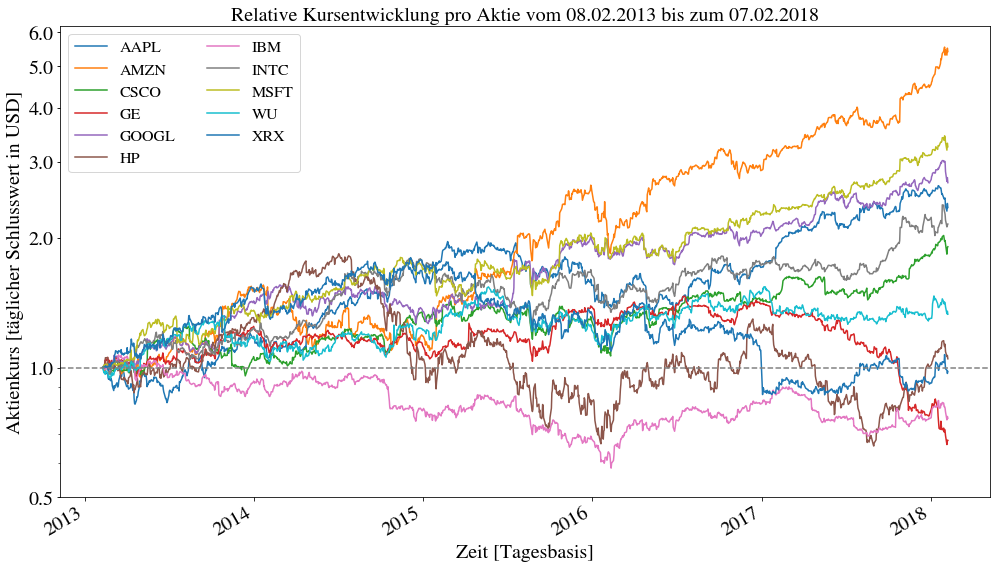

In [134]:
SAVE_FIG = True
labels = ["AAPL", "AMZN", "CSCO", "GE", "GOOGL", "HP", "IBM", "INTC", "MSFT", "WU", "XRX"]
colours = ["#e6eeff", "#b3cbff", "#80a8ff", "#4d85ff", "#3399ff", "#0066ff", "#0000ff", "#0033cc", "#003399", "#002266", "#001133"]
i = 0

ax = plt.gca()
for stock in TECH_GROUP:
    df = pd.read_csv(stock)
    # Visualize loaded time series data and plot, if applicable
    df["date"] = pd.to_datetime(df["date"])
    index = df["close"][0]
    df["close_indexed"] = df["close"]/index
    df.plot(x="date", y="close_indexed", figsize=(14,8), legend="Name", ax=ax, label=labels[i]) #color=colours[i]
    i = i + 1

plt.xlabel("Zeit [Tagesbasis]")
plt.ylabel("Aktienkurs [täglicher Schlusswert in USD]")
plt.title("Relative Kursentwicklung pro Aktie vom 08.02.2013 bis zum 07.02.2018")
plt.axhline(y=1, color="gray", ls="--")

import matplotlib.ticker
plt.legend(ncol=2)
ax.set_yscale("log")
ax.set_yticks([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.tight_layout()

if SAVE_FIG is True:
    plt.savefig("./Plots/Evaluation-Plots-04-Dez/All-Stocks-Price-Plots-log.jpeg")
# plt.close()

SAVE_FIG = False

## 6.2 | Reproduce "./Plots/Class-Balance-Check/"

In [135]:
SAVE_FIG = True
for stock in TECH_GROUP:
    df = load_OHLC_data(stock)
    df = define_classes(df)
    check_class_balance(df)
SAVE_FIG = False

## 6.3a | Reproduce f-measure final evaluation diagram (f-measure per stock per horizon)

In [136]:
SAVE_FIG = True
evaluation_model = DummyClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL] for single stock, [AAPL, XRX, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = True # Options: True, False
use_tuning = False # Options: True, False

g_classifier = "Dummy" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez"

# Dummy
final_fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
plot_fmeasure_bars(final_fmeasures_per_horizon)

# DT
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
final_fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
plot_fmeasure_bars(final_fmeasures_per_horizon)

# RF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
g_classifier = "RF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
final_fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
plot_fmeasure_bars(final_fmeasures_per_horizon)

# TunedDT
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
use_tuning = True
g_classifier = "TunedDT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
final_fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
plot_fmeasure_bars(final_fmeasures_per_horizon)

# TunedRF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
g_classifier = "TunedRF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
final_fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
plot_fmeasure_bars(final_fmeasures_per_horizon)
use_tuning = False

SAVE_FIG = False

announce_eval_settings() -> g_classifier=Dummy with type=<class 'sklearn.dummy.DummyClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, VERBOSE=F

get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=1 is precision=0.5568445475638051, recall=0.625, f_measure=0.5889570552147239
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=2 is precision=0.5626423690205011, recall=0.6449086161879896, f_measure=0.6009732360097324
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=3 is precision=0.5543478260869565, recall=0.6746031746031746, f_measure=0.6085918854415274
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=4 is precision=0.5191919191919192, recall=0.7158774373259053, f_measure=0.6018735362997658
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=5 is precision=0.6255707762557078, recall=0.6116071428571429, f_measure=0.618510158013544
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=0 is precision=0.5028735632183908, recall=0.5147058823529411, f_measure=0.5087209302325582
get_t

get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=3 is precision=0.5057915057915058, recall=0.34933333333333333, f_measure=0.41324921135646686
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=4 is precision=0.7855227882037533, recall=0.643956043956044, f_measure=0.7077294685990339
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=5 is precision=0.8619402985074627, recall=0.825, f_measure=0.843065693430657
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5204359673024523, recall=0.5552325581395349, f_measure=0.5372714486638538
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5236220472440944, recall=0.3877551020408163, f_measure=0.44556113902847566
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5537190082644629, recall=0.5742857142857143, f_measure=0.5638148667601683
get_tscv_co

get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=5 is precision=0.018518518518518517, recall=0.10256410256410256, f_measure=0.03137254901960784
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=0 is precision=0.514480408858603, recall=0.47634069400630913, f_measure=0.49467649467649466
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=1 is precision=0.5530650823656494, recall=0.5086934923000497, f_measure=0.529952128347781
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=2 is precision=0.5512895662368112, recall=0.46318640728884514, f_measure=0.5034122842232035
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=3 is precision=0.5402206080172182, recall=0.4973990587069606, f_measure=0.5179262316223884
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=4 is precision=0.6315663801337154, recall=0.6111367837338263, f_measure=0.6211836542977924
get_tscv_confusion_metrics()

get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=0 is precision=0.5027027027027027, recall=0.5391304347826087, f_measure=0.5202797202797202
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=1 is precision=0.5028735632183908, recall=0.5102040816326531, f_measure=0.5065123010130246
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=2 is precision=0.45103857566765576, recall=0.46060606060606063, f_measure=0.45577211394302847
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=3 is precision=0.41818181818181815, recall=0.42857142857142855, f_measure=0.42331288343558277
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=4 is precision=0.6024464831804281, recall=0.5397260273972603, f_measure=0.569364161849711
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=5 is precision=0.9086538461538461, recall=0.7907949790794979, f_measure=0.8456375838926173
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_INTC_2013-2

get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=2 is precision=0.6283422459893048, recall=0.5717761557177615, f_measure=0.5987261146496815
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=3 is precision=0.6568627450980392, recall=0.5968819599109132, f_measure=0.6254375729288215
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=4 is precision=0.6703786191536748, recall=0.6068548387096774, f_measure=0.6370370370370371
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=5 is precision=1.0, recall=0.9691176470588235, f_measure=0.9843166542195668
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=0 is precision=0.48, recall=0.5614035087719298, f_measure=0.5175202156334232
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=1 is precision=0.5465587044534413, recall=0.34704370179948585, f_measure=0.42452830188679247
get_tscv_confusion

get_tscv_confusion_metrics() -> Result on stock=WU, horizon=4 is precision=0.7554479418886199, recall=0.8020565552699229, f_measure=0.7780548628428927
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=5 is precision=0.6909975669099757, recall=0.7357512953367875, f_measure=0.71267252195734
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=0 is precision=0.5071090047393365, recall=0.6407185628742516, f_measure=0.5661375661375662
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=1 is precision=0.5591397849462365, recall=0.5959885386819485, f_measure=0.5769764216366158
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=2 is precision=0.514018691588785, recall=0.4824561403508772, f_measure=0.497737556561086
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=3 is precision=0.5220588235294118, recall=0.6740506329113924, f_measure=0.5883977900552487
get_

get_tscv_confusion_metrics() -> Result on stock=HP, horizon=0 is precision=0.47692307692307695, recall=0.5705521472392638, f_measure=0.5195530726256984
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=1 is precision=0.4575342465753425, recall=0.526813880126183, f_measure=0.4897360703812317
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=2 is precision=0.3980263157894737, recall=0.39672131147540984, f_measure=0.3973727422003284
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=3 is precision=0.3238341968911917, recall=0.45126353790613716, f_measure=0.37707390648567113
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=4 is precision=0.47345132743362833, recall=0.6881028938906752, f_measure=0.560943643512451
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=5 is precision=0.8263473053892215, recall=0.6330275229357798, f_measure=0.7168831168831169
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv
g

## 6.3b | Reproduce final tuning impact diagram

In [137]:
SAVE_FIG = True
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL] for single stock, [AAPL, XRX, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = True # Options: True, False
use_tuning = False # Options: True, False

g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez"

# 1a. DT
normal_fmeasures_dt = get_tscv_confusion_metrics(evaluation_model)
# 1b. TunedDT
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
use_tuning = True
g_classifier = "TunedDT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
tuned_fmeasures_dt = get_tscv_confusion_metrics(evaluation_model)
use_tuning = False
# 1c. DT tuning impact (diffs)
fdiffs_dt = []
for normal_fmeasures, tuned_fmeasures in zip(normal_fmeasures_dt, tuned_fmeasures_dt):
    diffs = []
    for i in range(len(normal_fmeasures)):
        diffs.extend([tuned_fmeasures[i]-normal_fmeasures[i]])
    fdiffs_dt.append(diffs)
print("fdiffs_dt: " + str(fdiffs_dt))
# with open("./Plots/Evaluation-Plots-Txts/Tuning-Impact-TBDTSCV-Diffs-" + str(g_classifier) + ".txt", "w") as f:
#     for item in fdiffs_dt:
#         f.write("%s\n" % str(item))
plot_tuning_diff_bars(fdiffs_dt)


# 2a. RF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
g_classifier = "RF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
normal_fmeasures_rf = get_tscv_confusion_metrics(evaluation_model)
# 2b. TunedRF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
use_tuning = True
g_classifier = "TunedRF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
tuned_fmeasures_rf = get_tscv_confusion_metrics(evaluation_model)
use_tuning = False
# 2c. DT tuning impact (diffs)
fdiffs_rf = []
for normal_fmeasures, tuned_fmeasures in zip(normal_fmeasures_rf, tuned_fmeasures_rf):
    diffs = []
    for i in range(len(normal_fmeasures)):
        diffs.extend([tuned_fmeasures[i]-normal_fmeasures[i]])
    fdiffs_rf.append(diffs)
print("fdiffs_rf: " + str(fdiffs_rf))
# with open("./Plots/Evaluation-Plots-Txts/Tuning-Impact-TBDTSCV-Diffs-" + str(g_classifier) + ".txt", "w") as f:
#     for item in fdiffs_rf:
#         f.write("%s\n" % str(item))
plot_tuning_diff_bars(fdiffs_rf)

SAVE_FIG = False

announce_eval_settings() -> g_classifier=DT with type=<class 'sklearn.tree.tree.DecisionTreeClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, V

get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=1 is precision=0.5804597701149425, recall=0.5260416666666666, f_measure=0.5519125683060109
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=2 is precision=0.5278969957081545, recall=0.32114882506527415, f_measure=0.39935064935064934
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=3 is precision=0.515748031496063, recall=0.34656084656084657, f_measure=0.4145569620253165
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=4 is precision=0.7509727626459144, recall=0.5376044568245125, f_measure=0.6266233766233766
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=5 is precision=0.8189189189189189, recall=0.6763392857142857, f_measure=0.7408312958435207
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=0 is precision=0.47410358565737054, recall=0.35, f_measure=0.4027072758037225
ge

get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=3 is precision=0.5343137254901961, recall=0.2906666666666667, f_measure=0.3765112262521588
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=4 is precision=0.7100271002710027, recall=0.5758241758241758, f_measure=0.6359223300970874
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=5 is precision=0.8855633802816901, recall=0.8982142857142857, f_measure=0.8918439716312058
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5114155251141552, recall=0.6511627906976745, f_measure=0.5728900255754475
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5406824146981627, recall=0.6005830903790087, f_measure=0.569060773480663
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5436893203883495, recall=0.48, f_measure=0.5098634294385432
get_tscv_confu

get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=5 is precision=0.005376344086021506, recall=0.02564102564102564, f_measure=0.008888888888888889
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=0 is precision=0.515309932785661, recall=0.5441640378548895, f_measure=0.5293440736478711
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=1 is precision=0.5470228158041179, recall=0.4883258817685047, f_measure=0.516010498687664
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=2 is precision=0.5561815336463224, recall=0.4375769514897808, f_measure=0.48980154355016536
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=3 is precision=0.550483351235231, recall=0.5078028238791181, f_measure=0.5282824378301766
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=4 is precision=0.6373748609566184, recall=0.6619685767097967, f_measure=0.6494389663379804
get_tscv_confusion_metrics() -

get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=3 is precision=0.6282894736842105, recall=0.4884910485933504, f_measure=0.5496402877697841
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=4 is precision=0.7302052785923754, recall=0.5724137931034483, f_measure=0.6417525773195876
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=5 is precision=0.9896193771626297, recall=0.896551724137931, f_measure=0.9407894736842105
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=0 is precision=0.4755043227665706, recall=0.5061349693251533, f_measure=0.4903417533432392
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=1 is precision=0.43291139240506327, recall=0.5394321766561514, f_measure=0.48033707865168535
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=2 is precision=0.45251396648044695, recall=0.5311475409836065, f_measure=0.48868778280

get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=0 is precision=0.5291970802919708, recall=0.4096045197740113, f_measure=0.46178343949044587
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=1 is precision=0.5330296127562643, recall=0.624, f_measure=0.574938574938575
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=2 is precision=0.5881006864988558, recall=0.658974358974359, f_measure=0.6215235792019348
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.6222760290556901, recall=0.6330049261083743, f_measure=0.6275946275946276
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.6708407871198568, recall=0.8047210300429185, f_measure=0.7317073170731707
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.8843373493975903, recall=0.8065934065934066, f_measure=0.8436781609195402
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv
get_t

get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=2 is precision=0.6565217391304348, recall=0.3793969849246231, f_measure=0.48089171974522293
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=3 is precision=0.6198630136986302, recall=0.434052757793765, f_measure=0.5105782792665726
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=4 is precision=0.8591549295774648, recall=0.6448202959830867, f_measure=0.7367149758454107
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=5 is precision=0.9542772861356932, recall=0.9969183359013868, f_measure=0.9751318764129616
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=0 is precision=0.5314685314685315, recall=0.4523809523809524, f_measure=0.4887459807073955
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=1 is precision=0.5144694533762058, recall=0.43010752688172044, f_measure=0.4685212298682

## 6.3c | Reproduce feature engineering impact diagram (f-measure difference per classifier)

In [138]:
SAVE_FIG = True
evaluation_model = DummyClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL] for single stock, [AAPL, XRX, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = False # Options: True, False
use_tuning = False # Options: True, False

g_classifier = "" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez"

get_extracteds_impact()

SAVE_FIG = False

announce_eval_settings() -> g_classifier= with type=<class 'sklearn.dummy.DummyClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez
announce_eval_settings() -> use_feature_extraction=False, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, VERBOSE=False

get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=1 is precision=0.5568445475638051, recall=0.625, f_measure=0.5889570552147239
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=2 is precision=0.5626423690205011, recall=0.6449086161879896, f_measure=0.6009732360097324
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=3 is precision=0.5543478260869565, recall=0.6746031746031746, f_measure=0.6085918854415274
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=4 is precision=0.5191919191919192, recall=0.7158774373259053, f_measure=0.6018735362997658
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=5 is precision=0.6255707762557078, recall=0.6116071428571429, f_measure=0.618510158013544
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=0 is precision=0.5028735632183908, recall=0.5147058823529411, f_measure=0.5087209302325582
get_t

get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=3 is precision=0.5951417004048583, recall=0.392, f_measure=0.47266881028938906
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=4 is precision=0.6940509915014165, recall=0.5384615384615384, f_measure=0.6064356435643565
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=5 is precision=0.9420289855072463, recall=0.6964285714285714, f_measure=0.8008213552361396
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5246376811594203, recall=0.5261627906976745, f_measure=0.525399129172714
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5580736543909348, recall=0.5743440233236151, f_measure=0.5660919540229884
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5860805860805861, recall=0.45714285714285713, f_measure=0.5136436597110754
get_tscv_co

get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=5 is precision=0.043478260869565216, recall=0.1794871794871795, f_measure=0.06999999999999999
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=0 is precision=0.513317892298784, recall=0.46608832807570977, f_measure=0.48856434279415817
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=1 is precision=0.5470108695652174, recall=0.5, f_measure=0.5224500389307033
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=2 is precision=0.5674761758376883, recall=0.45456784043339077, f_measure=0.5047853431774678
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=3 is precision=0.579136690647482, recall=0.5184542977458508, f_measure=0.5471180237877401
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=4 is precision=0.6413431769468921, recall=0.6222273567467652, f_measure=0.631640670810367
get_tscv_confusion_metrics() -> Result on sto

get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=0 is precision=0.5268817204301075, recall=0.7101449275362319, f_measure=0.6049382716049383
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=1 is precision=0.4746666666666667, recall=0.5189504373177842, f_measure=0.4958217270194986
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=2 is precision=0.4341736694677871, recall=0.4696969696969697, f_measure=0.45123726346433773
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=3 is precision=0.38095238095238093, recall=0.2981366459627329, f_measure=0.33449477351916374
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=4 is precision=0.5775577557755776, recall=0.4794520547945205, f_measure=0.5239520958083832
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=5 is precision=0.8008474576271186, recall=0.7907949790794979, f_measure=0.7957894736842106
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_INTC_2013-201

get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=2 is precision=0.520618556701031, recall=0.24574209245742093, f_measure=0.3338842975206611
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=3 is precision=0.6923076923076923, recall=0.26057906458797325, f_measure=0.37864077669902907
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=4 is precision=0.7250608272506083, recall=0.6008064516129032, f_measure=0.6571113561190739
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=5 is precision=1.0, recall=0.9691176470588235, f_measure=0.9843166542195668
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=0 is precision=0.48672566371681414, recall=0.4824561403508772, f_measure=0.48458149779735676
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=1 is precision=0.6058981233243967, recall=0.5809768637532133, f_measure=0.5931758530183727
ge

get_tscv_confusion_metrics() -> Result on stock=WU, horizon=4 is precision=0.6442577030812325, recall=0.5912596401028277, f_measure=0.6166219839142092
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=5 is precision=0.7199017199017199, recall=0.7590673575129534, f_measure=0.7389659520807061
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=0 is precision=0.4988610478359909, recall=0.655688622754491, f_measure=0.5666235446313066
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=1 is precision=0.5162393162393163, recall=0.8653295128939829, f_measure=0.6466809421841543
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=2 is precision=0.5685185185185185, recall=0.8976608187134503, f_measure=0.6961451247165532
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=3 is precision=0.5113871635610766, recall=0.7816455696202531, f_measure=0.6182728410513142
g

get_tscv_confusion_metrics() -> Result on stock=HP, horizon=0 is precision=0.48055555555555557, recall=0.5306748466257669, f_measure=0.5043731778425655
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=1 is precision=0.4304635761589404, recall=0.41009463722397477, f_measure=0.420032310177706
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=2 is precision=0.43728813559322033, recall=0.42295081967213116, f_measure=0.42999999999999994
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=3 is precision=0.4250614250614251, recall=0.6245487364620939, f_measure=0.5058479532163743
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=4 is precision=0.6498316498316499, recall=0.6205787781350482, f_measure=0.6348684210526315
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=5 is precision=0.7005347593582888, recall=0.6009174311926605, f_measure=0.6469135802469136
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv


get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=2 is precision=0.54627539503386, recall=0.6205128205128205, f_measure=0.5810324129651862
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.5987261146496815, recall=0.6945812807881774, f_measure=0.6431014823261118
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.6863084922010398, recall=0.8497854077253219, f_measure=0.7593480345158199
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.6564885496183206, recall=0.756043956043956, f_measure=0.7027579162410622
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=0 is precision=0.5328282828282829, recall=0.5733695652173914, f_measure=0.5523560209424084
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=1 is precision=0.5815789473684211, recall=0.5497512437810945, f_measure=0.56521739130

get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=4 is precision=0.6907407407407408, recall=0.7885835095137421, f_measure=0.736426456071076
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=5 is precision=0.9499192245557351, recall=0.9060092449922958, f_measure=0.9274447949526815
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=0 is precision=0.5040871934604905, recall=0.5505952380952381, f_measure=0.5263157894736842
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=1 is precision=0.5725, recall=0.6155913978494624, f_measure=0.5932642487046632
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=2 is precision=0.5440806045340051, recall=0.5714285714285714, f_measure=0.5574193548387097
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=3 is precision=0.5272727272727272, recall=0.5456989247311828, f_measure=0.5363276089828269
get_tscv_confu

get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=0 is precision=0.5333333333333333, recall=0.5139664804469274, f_measure=0.5234708392603129
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=1 is precision=0.553030303030303, recall=0.5918918918918918, f_measure=0.5718015665796343
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=2 is precision=0.571917808219178, recall=0.4260204081632653, f_measure=0.4883040935672515
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=3 is precision=0.579746835443038, recall=0.5856777493606138, f_measure=0.5826972010178116
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=4 is precision=0.6888361045130641, recall=0.6666666666666666, f_measure=0.677570093457944
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=5 is precision=0.9470198675496688, recall=0.896551724137931, f_measure=0.9210950080515298
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_HP_2013-2

get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=0 is precision=0.5078947368421053, recall=0.5451977401129944, f_measure=0.5258855585831063
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=1 is precision=0.5647921760391198, recall=0.616, f_measure=0.5892857142857143
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=2 is precision=0.5779569892473119, recall=0.5512820512820513, f_measure=0.5643044619422573
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.6474164133738601, recall=0.5246305418719212, f_measure=0.5795918367346938
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.6906854130052724, recall=0.8433476394849786, f_measure=0.7594202898550725
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.866504854368932, recall=0.7846153846153846, f_measure=0.8235294117647058
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv
get_t

get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=2 is precision=0.7289377289377289, recall=0.5, f_measure=0.593144560357675
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=3 is precision=0.5957446808510638, recall=0.4028776978417266, f_measure=0.48068669527896996
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=4 is precision=0.8758949880668258, recall=0.7758985200845666, f_measure=0.8228699551569506
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=5 is precision=0.9498381877022654, recall=0.9044684129429892, f_measure=0.9265982636148381
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=0 is precision=0.5492424242424242, recall=0.43154761904761907, f_measure=0.48333333333333334
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=1 is precision=0.5816326530612245, recall=0.4596774193548387, f_measure=0.5135135135135135
get_tscv_c

get_tscv_confusion_metrics() -> Result on stock=GE, horizon=4 is precision=0.6388140161725068, recall=0.7095808383233533, f_measure=0.6723404255319149
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=5 is precision=0.7213822894168467, recall=0.8675324675324675, f_measure=0.7877358490566038
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=0 is precision=0.5925925925925926, recall=0.4022346368715084, f_measure=0.47920133111480867
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=1 is precision=0.5389048991354467, recall=0.5054054054054054, f_measure=0.5216178521617852
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=2 is precision=0.6013513513513513, recall=0.45408163265306123, f_measure=0.5174418604651162
get_tscv_confusion_metrics() -> Result on stock=GOOGL, horizon=3 is precision=0.5607843137254902, recall=0.3657289002557545, f_measure=0.44272

get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=0 is precision=0.5291970802919708, recall=0.4096045197740113, f_measure=0.46178343949044587
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=1 is precision=0.5330296127562643, recall=0.624, f_measure=0.574938574938575
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=2 is precision=0.5881006864988558, recall=0.658974358974359, f_measure=0.6215235792019348
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.6222760290556901, recall=0.6330049261083743, f_measure=0.6275946275946276
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.6708407871198568, recall=0.8047210300429185, f_measure=0.7317073170731707
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.8843373493975903, recall=0.8065934065934066, f_measure=0.8436781609195402
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv
get_t

get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=2 is precision=0.6565217391304348, recall=0.3793969849246231, f_measure=0.48089171974522293
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=3 is precision=0.6198630136986302, recall=0.434052757793765, f_measure=0.5105782792665726
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=4 is precision=0.8591549295774648, recall=0.6448202959830867, f_measure=0.7367149758454107
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=5 is precision=0.9542772861356932, recall=0.9969183359013868, f_measure=0.9751318764129616
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=0 is precision=0.5314685314685315, recall=0.4523809523809524, f_measure=0.4887459807073955
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=1 is precision=0.5144694533762058, recall=0.43010752688172044, f_measure=0.4685212298682

## 6.3d | Reproduce "./Plots/Confusion-Matrices-(Model)-Adjusted/"
- First specify evaluation settings, then plot confusion matrices

In [139]:
SAVE_FIG = True
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL] for single stock, [AAPL, XRX, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = True # Options: True, False
use_tuning = False # Options: True, False

evaluation_model = DummyClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
g_classifier = "Dummy" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez/Confusions" # g_plot_folder = "Confusion-Matrices-" + str(g_classifier) + "-Adjusted"
get_tscv_confusion_metrics(evaluation_model)
print("\n\n")

evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez/Confusions"
get_tscv_confusion_metrics(evaluation_model)
print("\n\n")

evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
g_classifier = "RF" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez/Confusions"
get_tscv_confusion_metrics(evaluation_model)
print("\n\n")

use_tuning = True
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
g_classifier = "TunedDT" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez/Confusions"
get_tscv_confusion_metrics(evaluation_model)
print("\n\n")

evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
g_classifier = "TunedRF" # Options: "Dummy", "DT", "TunedDT", "RF", "TunedRF"
g_plot_folder = "Evaluation-Plots-04-Dez/Confusions"
get_tscv_confusion_metrics(evaluation_model)
print("\n\n")
use_tuning = False

SAVE_FIG = False

announce_eval_settings() -> g_classifier=Dummy with type=<class 'sklearn.dummy.DummyClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez/Confusions
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True

get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=1 is precision=0.5568445475638051, recall=0.625, f_measure=0.5889570552147239
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=2 is precision=0.5626423690205011, recall=0.6449086161879896, f_measure=0.6009732360097324
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=3 is precision=0.5543478260869565, recall=0.6746031746031746, f_measure=0.6085918854415274
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=4 is precision=0.5191919191919192, recall=0.7158774373259053, f_measure=0.6018735362997658
get_tscv_confusion_metrics() -> Result on stock=INTC, horizon=5 is precision=0.6255707762557078, recall=0.6116071428571429, f_measure=0.618510158013544
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=MSFT, horizon=0 is precision=0.5028735632183908, recall=0.5147058823529411, f_measure=0.5087209302325582
get_t

get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=3 is precision=0.5057915057915058, recall=0.34933333333333333, f_measure=0.41324921135646686
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=4 is precision=0.7855227882037533, recall=0.643956043956044, f_measure=0.7077294685990339
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=5 is precision=0.8619402985074627, recall=0.825, f_measure=0.843065693430657
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5204359673024523, recall=0.5552325581395349, f_measure=0.5372714486638538
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5236220472440944, recall=0.3877551020408163, f_measure=0.44556113902847566
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5537190082644629, recall=0.5742857142857143, f_measure=0.5638148667601683
get_tscv_co

get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=5 is precision=0.018518518518518517, recall=0.10256410256410256, f_measure=0.03137254901960784
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=0 is precision=0.514480408858603, recall=0.47634069400630913, f_measure=0.49467649467649466
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=1 is precision=0.5530650823656494, recall=0.5086934923000497, f_measure=0.529952128347781
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=2 is precision=0.5512895662368112, recall=0.46318640728884514, f_measure=0.5034122842232035
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=3 is precision=0.5402206080172182, recall=0.4973990587069606, f_measure=0.5179262316223884
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=4 is precision=0.6315663801337154, recall=0.6111367837338263, f_measure=0.6211836542977924
get_tscv_confusion_metrics()

get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=0 is precision=0.5027027027027027, recall=0.5391304347826087, f_measure=0.5202797202797202
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=1 is precision=0.5028735632183908, recall=0.5102040816326531, f_measure=0.5065123010130246
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=2 is precision=0.45103857566765576, recall=0.46060606060606063, f_measure=0.45577211394302847
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=3 is precision=0.41818181818181815, recall=0.42857142857142855, f_measure=0.42331288343558277
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=4 is precision=0.6024464831804281, recall=0.5397260273972603, f_measure=0.569364161849711
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=5 is precision=0.9086538461538461, recall=0.7907949790794979, f_measure=0.8456375838926173
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_INTC_2013-2

get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=2 is precision=0.6283422459893048, recall=0.5717761557177615, f_measure=0.5987261146496815
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=3 is precision=0.6568627450980392, recall=0.5968819599109132, f_measure=0.6254375729288215
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=4 is precision=0.6703786191536748, recall=0.6068548387096774, f_measure=0.6370370370370371
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=5 is precision=1.0, recall=0.9691176470588235, f_measure=0.9843166542195668
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=0 is precision=0.48, recall=0.5614035087719298, f_measure=0.5175202156334232
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=1 is precision=0.5465587044534413, recall=0.34704370179948585, f_measure=0.42452830188679247
get_tscv_confusion

get_tscv_confusion_metrics() -> Result on stock=WU, horizon=4 is precision=0.7554479418886199, recall=0.8020565552699229, f_measure=0.7780548628428927
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=5 is precision=0.6909975669099757, recall=0.7357512953367875, f_measure=0.71267252195734
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=0 is precision=0.5071090047393365, recall=0.6407185628742516, f_measure=0.5661375661375662
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=1 is precision=0.5591397849462365, recall=0.5959885386819485, f_measure=0.5769764216366158
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=2 is precision=0.514018691588785, recall=0.4824561403508772, f_measure=0.497737556561086
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=3 is precision=0.5220588235294118, recall=0.6740506329113924, f_measure=0.5883977900552487
get_

get_tscv_confusion_metrics() -> Result on stock=HP, horizon=0 is precision=0.47692307692307695, recall=0.5705521472392638, f_measure=0.5195530726256984
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=1 is precision=0.4575342465753425, recall=0.526813880126183, f_measure=0.4897360703812317
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=2 is precision=0.3980263157894737, recall=0.39672131147540984, f_measure=0.3973727422003284
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=3 is precision=0.3238341968911917, recall=0.45126353790613716, f_measure=0.37707390648567113
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=4 is precision=0.47345132743362833, recall=0.6881028938906752, f_measure=0.560943643512451
get_tscv_confusion_metrics() -> Result on stock=HP, horizon=5 is precision=0.8263473053892215, recall=0.6330275229357798, f_measure=0.7168831168831169
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv
g

## 6.3z Reproduce Stock Plots, 6a and 6b with stock groupings (3 groups based on trend)
- Group 1 -> upward trend, Group 2 -> alternating trend, Group 3 -> downward trend

### Stock Plots for groups

In [142]:
SAVE_FIG = True
groups = [[AAPL_DATA, AMZN_DATA, CSCO_DATA, GOOGL_DATA, INTC_DATA, MSFT_DATA], [GE_DATA, HP_DATA, WU_DATA, XRX_DATA], [IBM_DATA]]
labels = [["AAPL", "AMZN", "CSCO", "GOOGL" ,"INTC", "MSFT"], ["GE",  "HP", "WU", "XRX"], ["IBM"]]
colours = [["#b3cbff", "#4d85ff", "#3399ff", "#0000ff", "#003399", "#001133"], ["#b3cbff", "#4d85ff", "#0000ff", "#001133"], ["#0000ff"]]
group_counter = 1

# 1. Plot stock performance per group with index=100
import matplotlib.ticker
for g in groups:
    i = 0
    ax = plt.gca()
    for stock in g:
        df = pd.read_csv(stock)
        # Visualize loaded time series data and plot, if applicable
        df["date"] = pd.to_datetime(df["date"])
        index = df["close"][0]
        df["close_indexed"] = df["close"]/index
        df.plot(x="date", y="close_indexed", figsize=(14,8), legend="Name", ax=ax, label=labels[group_counter-1][i]) #color=colours[i]
        i = i + 1
    plt.xlabel("Zeit [Tagesbasis]")
    plt.ylabel("Aktienkurs [täglicher Schlusswert in USD]")
    plt.title("Gruppe " + str(group_counter) + ": Relative Kursentwicklung pro Aktie vom 08.02.2013 bis zum 07.02.2018")
    plt.axhline(y=1, color="gray", ls="--")
    plt.legend(ncol=2)
    ax.set_yscale("log")
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.tight_layout()
    if SAVE_FIG is True:
        plt.savefig("./Plots/Evaluation-Plots-04-Dez/" + "Group" + str(group_counter) + "-Price-Plots-log.jpeg")
    plt.close()
    group_counter = group_counter + 1

SAVE_FIG = False

### 6.3a for groups (f-measures per stock group)

In [143]:
SAVE_FIG = True
groups = [[AAPL_DATA, AMZN_DATA, CSCO_DATA, GOOGL_DATA, INTC_DATA, MSFT_DATA], [GE_DATA, HP_DATA, WU_DATA, XRX_DATA], [IBM_DATA]]
labels = [["AAPL", "AMZN", "CSCO", "GOOGL" ,"INTC", "MSFT"], ["GE",  "HP", "WU", "XRX"], ["IBM"]]
colours = [["#b3cbff", "#4d85ff", "#3399ff", "#0000ff", "#003399", "#001133", "w", "black", "w", "w"], ["#b3cbff", "#4d85ff", "#0000ff", "#001133", "w", "black", "w", "w"], ["#0000ff", "w", "black", "w", "w"]]
models = [DummyClassifier(random_state=RANDOM_SEED), DecisionTreeClassifier(random_state=RANDOM_SEED), RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)]
g_classifiers = ["Dummy", "TunedDummy", "DT", "TunedDT", "RF", "TunedRF"]
group_xticks = [[4, 14, 24, 34, 44, 54], [3, 11, 19, 27, 35, 43], [1, 6, 11, 16, 21, 26]]
g_classifier_i = 0
group_counter = 1

for g in groups:
    with open("./Plots/Evaluation-Plots-Txts/Master-FMeasures-Adjusted.txt", "a") as f:
        f.write("\nGroup %s\n" % str(group_counter))
    g_classifier_i = 0
    for m in models:
        with open("./Plots/Evaluation-Plots-Txts/Master-FMeasures-Adjusted.txt", "a") as f:
            f.write("\nModel %s\n" % str(g_classifier))
        for t in [False, True]:
            evaluation_model = m
            evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
            evaluation_datasets = g
            use_feature_extraction = True
            use_tuning = t
            g_classifier = g_classifiers[g_classifier_i]
            # 0. Get Confusion metrics
            fmeasures_per_horizon = get_tscv_confusion_metrics(evaluation_model)
            # 1. Declare variables and give extra space to the Tech-Group average (thick bar in diagram)
            fmeasures_stock = []
            for fmeasures_horizon in fmeasures_per_horizon:
                for i in range(len(fmeasures_horizon)-1):
                    fmeasures_stock.extend([fmeasures_horizon[i]])
                fmeasures_stock.extend([0]) # get extra spcace for Tech-Group average
                fmeasures_stock.extend([fmeasures_horizon[-1]])
                fmeasures_stock.extend([0]) # get extra spcace for Tech-Group average
                fmeasures_stock.extend([0]) # separate bars from different horizons
            x_values = range(len(fmeasures_stock))
            # 2. Plot bar charts
            label_i = 0
            for i in range(len(x_values)):
                if i+1 < len(x_values) and (fmeasures_stock[i-1] == 0 and fmeasures_stock[i+1] == 0):
                    plt.bar(x_values[i], fmeasures_stock[i], width=2.3, color=colours[group_counter-1][i%len(colours[group_counter-1])])
                else:
                    plt.bar(x_values[i], fmeasures_stock[i], width=0.7, color=colours[group_counter-1][i%len(colours[group_counter-1])])
                label_i = label_i + 1
            # 3. Design diagram incl. legend
            plt.xlabel("Zeithorizont")
            plt.ylabel("F-Maß")
            plt.title("Gruppe " + str(group_counter) + ": F-Maße pro Horizont (" + str(g_classifier) + ")")
            plt.xticks(group_xticks[group_counter-1], ["1d", "5d", "10d", "20d", "65d", "250d"])
            plt.axhline(y=0.5,color="gray", ls="--")
            fig = plt.gcf()
            fig.set_size_inches(14, 8)
            axes = plt.gca()
            axes.set_ylim([0.0, 1.0])
            
            patches = [mpatches.Patch(color=colours[group_counter-1][i], label=labels[group_counter-1][i]) for i in range(len(labels[group_counter-1]))]
            patches.extend([mpatches.Patch(color="black", label="Durchschnitt")])
            plt.legend(handles=patches, ncol=2)
            plt.tight_layout()

            if SAVE_FIG is True:
                plt.savefig("./Plots/Evaluation-Plots-04-Dez/Group" + str(group_counter) + "-Final-FMeasure-Evaluations-" + str(g_classifier) + ".jpeg")
            plt.close()
            
            g_classifier_i = g_classifier_i + 1
    group_counter = group_counter + 1

announce_eval_settings() -> g_classifier=Dummy with type=<class 'sklearn.dummy.DummyClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez/Confusions
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, VERBOSE=False
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=0 is precision=0.5333333333333333, recall=0.5875706214689266, f_measure=0.5591397849462365
get_tscv_con

get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=0 is precision=0.5333333333333333, recall=0.5875706214689266, f_measure=0.5591397849462365
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=1 is precision=0.535632183908046, recall=0.6213333333333333, f_measure=0.5753086419753086
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=2 is precision=0.54627539503386, recall=0.6205128205128205, f_measure=0.5810324129651862
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.5987261146496815, recall=0.6945812807881774, f_measure=0.6431014823261118
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.6863084922010398, recall=0.8497854077253219, f_measure=0.7593480345158199
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.6564885496183206, recall=0.756043956043956, f_measure=0.7027579162410622
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018

get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=3 is precision=0.6017130620985011, recall=0.6921182266009852, f_measure=0.6437571592210768
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=4 is precision=0.8018018018018018, recall=0.7639484978540773, f_measure=0.7824175824175824
get_tscv_confusion_metrics() -> Result on stock=AAPL, horizon=5 is precision=0.9052631578947369, recall=0.756043956043956, f_measure=0.8239520958083831
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=0 is precision=0.5546218487394958, recall=0.358695652173913, f_measure=0.43564356435643564
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=1 is precision=0.6060606060606061, recall=0.44776119402985076, f_measure=0.5150214592274679
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=2 is precision=0.6027713625866051, recall=0.635036496350365, f_measure=0.618483412

get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=0 is precision=0.5708812260536399, recall=0.4048913043478261, f_measure=0.47376788553259147
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=1 is precision=0.565068493150685, recall=0.41044776119402987, f_measure=0.4755043227665706
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=2 is precision=0.6283422459893048, recall=0.5717761557177615, f_measure=0.5987261146496815
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=3 is precision=0.6568627450980392, recall=0.5968819599109132, f_measure=0.6254375729288215
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=4 is precision=0.6703786191536748, recall=0.6068548387096774, f_measure=0.6370370370370371
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=5 is precision=1.0, recall=0.9691176470588235, f_measure=0.9843166542195668
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv
get_t

get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=3 is precision=0.6674937965260546, recall=0.5991091314031181, f_measure=0.6314553990610329
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=4 is precision=0.7061503416856492, recall=0.625, f_measure=0.6631016042780749
get_tscv_confusion_metrics() -> Result on stock=AMZN, horizon=5 is precision=1.0, recall=0.9764705882352941, f_measure=0.988095238095238
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=0 is precision=0.48333333333333334, recall=0.5087719298245614, f_measure=0.4957264957264957
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=1 is precision=0.5454545454545454, recall=0.46272493573264784, f_measure=0.5006954102920723
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=2 is precision=0.6490683229813664, recall=0.5471204188481675, f_measure=0.5937499999999999
get_tscv_confusion

get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=0 is precision=0.4804270462633452, recall=0.39473684210526316, f_measure=0.4333868378812199
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=1 is precision=0.553125, recall=0.455012853470437, f_measure=0.4992947813822285
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=2 is precision=0.577639751552795, recall=0.4869109947643979, f_measure=0.5284090909090908
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=3 is precision=0.6654411764705882, recall=0.4826666666666667, f_measure=0.5595054095826894
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=4 is precision=0.7255936675461742, recall=0.6043956043956044, f_measure=0.6594724220623501
get_tscv_confusion_metrics() -> Result on stock=CSCO, horizon=5 is precision=0.8528138528138528, recall=0.7035714285714286, f_measure=0.7710371819960861
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv
g

get_tscv_confusion_metrics() -> Result on stock=WU, horizon=4 is precision=0.5603271983640081, recall=0.7043701799485861, f_measure=0.6241457858769932
get_tscv_confusion_metrics() -> Result on stock=WU, horizon=5 is precision=0.5797872340425532, recall=0.8471502590673575, f_measure=0.6884210526315788
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=0 is precision=0.5359281437125748, recall=0.5359281437125748, f_measure=0.5359281437125748
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=1 is precision=0.4954128440366973, recall=0.6189111747851003, f_measure=0.5503184713375797
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=2 is precision=0.5067264573991032, recall=0.6608187134502924, f_measure=0.5736040609137056
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=3 is precision=0.47835497835497837, recall=0.6993670886075949, f_measure=0.5681233933161954

get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5204359673024523, recall=0.5552325581395349, f_measure=0.5372714486638538
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5236220472440944, recall=0.3877551020408163, f_measure=0.44556113902847566
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5537190082644629, recall=0.5742857142857143, f_measure=0.5638148667601683
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=3 is precision=0.5579514824797843, recall=0.6197604790419161, f_measure=0.5872340425531914
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=4 is precision=0.4115755627009646, recall=0.38323353293413176, f_measure=0.3968992248062016
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=5 is precision=0.8494623655913979, recall=0.8207792207792208, f_measure=0.834874504623514
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv
get_

get_tscv_confusion_metrics() -> Result on stock=WU, horizon=5 is precision=0.6909975669099757, recall=0.7357512953367875, f_measure=0.71267252195734
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=0 is precision=0.5071090047393365, recall=0.6407185628742516, f_measure=0.5661375661375662
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=1 is precision=0.5591397849462365, recall=0.5959885386819485, f_measure=0.5769764216366158
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=2 is precision=0.514018691588785, recall=0.4824561403508772, f_measure=0.497737556561086
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=3 is precision=0.5220588235294118, recall=0.6740506329113924, f_measure=0.5883977900552487
get_tscv_confusion_metrics() -> Result on stock=XRX, horizon=4 is precision=0.3233256351039261, recall=0.5714285714285714, f_measure=0.4129793510324483
get

get_tscv_confusion_metrics() -> Result on stock=GE, horizon=0 is precision=0.5087209302325582, recall=0.5087209302325582, f_measure=0.5087209302325582
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=1 is precision=0.5761194029850746, recall=0.5626822157434402, f_measure=0.5693215339233039
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=2 is precision=0.5681818181818182, recall=0.5714285714285714, f_measure=0.5698005698005698
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=3 is precision=0.580327868852459, recall=0.5299401197604791, f_measure=0.5539906103286385
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=4 is precision=0.7017045454545454, recall=0.7395209580838323, f_measure=0.7201166180758016
get_tscv_confusion_metrics() -> Result on stock=GE, horizon=5 is precision=0.8089622641509434, recall=0.8909090909090909, f_measure=0.8479604449938195
get_tscv_confusion_metrics() -> Stock=../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv
get_ts

get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=3 is precision=0.4555160142348754, recall=0.39751552795031053, f_measure=0.4245439469320066
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=4 is precision=0.5269709543568465, recall=0.34794520547945207, f_measure=0.41914191419141916
get_tscv_confusion_metrics() -> Result on stock=IBM, horizon=5 is precision=0.5119047619047619, recall=0.1799163179916318, f_measure=0.2662538699690402
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=0 is precision=0.5324232081911263, recall=0.45217391304347826, f_measure=0.4890282131661442
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=1 is precision=0.5121293800539084, recall=0.5539358600583091, f_measure=0.5322128851540617
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=2 is precision=0.5482758620689655, recall=0.4818181818181818, f_measure=0.5129032258064516
get_tscv_confusion_metrics() -> Result on stock=Tec

get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=3 is precision=0.41818181818181815, recall=0.42857142857142855, f_measure=0.42331288343558277
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=4 is precision=0.6024464831804281, recall=0.5397260273972603, f_measure=0.569364161849711
get_tscv_confusion_metrics() -> Result on stock=Tech-Group-AVG, horizon=5 is precision=0.9086538461538461, recall=0.7907949790794979, f_measure=0.8456375838926173
announce_eval_settings() -> g_classifier=TunedRF with type=<class 'sklearn.ensemble.forest.RandomForestClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez/Confusions
announce_eval_settings() -> use_feature_extraction=True, use_tuning=True
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, VERBOSE=False
get_tscv_confusion_metrics() 

### 6.3b for groups (final tuning impact per stock group)

In [144]:
# # Idea: Use .txt results from before (6b)
txt_results_dt = [[0.005739970296932295, 0.03812432117615583, 0.07057487801284446, 0.03561857691159376, -0.04426950814550423, 0.010000699349604902, -0.00657392939560808, 0.11726376995214871, 0.10556340088800681, -0.06577569963012064, 0.1062950464525268, 0.0346675789713764], [-0.045873500101688, -0.03951713646089727, -0.12421821621905715, 0.12349963445218731, -0.05018371441784908, 0.06994358324181904, 0.03161584725739963, -0.08894960534304791, -0.0349054286416115, 0.0032192561042047596, 0.040663572474604615, -0.013941629660117028], [0.06827032640521558, -0.019757297672593377, -0.04301666310399932, -0.053951437321625106, 0.02913776689786468, 0.06526806526806533, -0.09342866695815433, 0.07269904009034445, -0.035942902430740054, -0.03256181276957659, -0.08135091528877991, -0.013610740673038135], [-0.07879887555003995, 0.1428713246721967, -0.036737985104308035, 0.06623130398146193, -0.1399727428134772, 0.06306139197104088, -0.08130602286852534, 0.10860380091746275, -0.08717332133452327, 0.15303736323757838, 0.016491435540198607, 0.01035620620778821], [-0.08823768823768818, 0.07475132275132279, -0.07180713850194642, 0.27544120072571326, -0.010146710938080061, 0.10563538392456218, -0.09303091569752175, 0.0347099567099568, 0.07709103394258698, 0.13844846677893208, -0.07812385181452675, 0.02825531204018794], [0.07754683352780545, 0.021692703037263228, 0.04877827820054881, -0.047138655566910215, -0.01745128335517343, 0.0, -0.1590492840492841, 0.02599562723340232, -0.02823646128456836, -0.05816081137599327, -0.022483660130718952, -0.0008828568939311943]]
txt_results_rf = [[-0.06410211909266039, 0.08475560403983523, -0.06233965784527579, -0.04744345332908573, 0.020411351424683533, 0.02921131928245918, 0.043382654541452736, 0.02060160700699587, 0.03089581304771183, 0.005412647374062163, 0.03955030660913017, 0.009619437634472261], [-0.01434713934713927, 0.02283695901977073, -0.0014006289098438263, 0.02886351865612835, -0.010781660857335007, 0.009398991729546335, 0.00807655840342103, 0.021120634662893267, -0.06334485057889316, -0.044992283645285125, 0.16943866943866948, 0.015645869841803273], [0.05721911725967754, -0.048886571948771385, -0.06534090909090906, 0.019872928700714443, -0.020299963564167856, -0.09131504060510143, 0.0622134975677629, 0.1001264060832312, -0.11225284061245211, -0.01931514178705196, 0.03645380702425227, -0.0033371337401814083], [0.04800279085993375, -0.025098430845874042, 0.012168131476180455, -0.08424468378900862, 0.07503162824071463, -0.05886129233612564, -0.05531288343558277, 0.045139854736516716, 0.029891583987602666, 0.0690119899618924, 0.051978150358371944, 0.012046267367583074], [-0.027712972781901768, -0.13431194505363298, 0.02333380820096398, 0.005210684645989727, 0.026558150177329876, 0.015244718781268207, -0.13241401522214497, -0.04852390622625624, -0.08615497931153993, -0.09973239662601985, -0.043661021109474674, -0.04707417001111458], [0.020148749154834333, -0.0007534659433393598, -0.10724908869524796, 0.03949981044622852, 0.030410526315789554, -0.029919952170591513, 0.0069701258579496495, 0.015477595259947186, 0.048533612798123515, 0.0010975145141052245, -0.012799073835863133, 0.0040585877763811284]]

SAVE_FIG = True
groups = [[0, 1, 2, 4, 7, 8], [3, 5, 9, 10], [6]]
labels = [["AAPL", "AMZN", "CSCO", "GOOGL" ,"INTC", "MSFT"], ["GE",  "HP", "WU", "XRX"], ["IBM"]]
colours = [["#b3cbff", "#4d85ff", "#3399ff", "#0000ff", "#003399", "#001133", "w", "black", "w", "w"], ["#b3cbff", "#4d85ff", "#0000ff", "#001133", "w", "black", "w", "w"], ["#0000ff", "w", "black", "w", "w"]]
colours = [["#b3cbff", "#4d85ff", "#3399ff", "#0000ff", "#003399", "#001133", "w", "black", "w", "w"], ["#b3cbff", "#4d85ff", "#0000ff", "#001133", "w", "black", "w", "w"], ["#0000ff", "w", "black", "w", "w"]]

g_classifiers = ["TunedDT", "TunedRF"]
group_xticks = [[4, 14, 24, 34, 44, 54], [3, 11, 19, 27, 35, 43], [1, 6, 11, 16, 21, 26]]
group_counter = 1

evaluation_model = None
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = None
use_feature_extraction = True
    
# Step 1: DT
for group_indices in groups:
    g_classifier = g_classifiers[0] # DT
    # 1. Get diffs
    diffs = []
    for diffs_horizon in txt_results_dt:
        for i in group_indices:
            diffs.extend([diffs_horizon[i]])
        diffs.extend([0]) # get extra spcace for average
        group_avg = sum([diffs_horizon[j] for j in group_indices])/len(group_indices)
        diffs.extend([group_avg])
        diffs.extend([0]) # get extra spcace for average
        diffs.extend([0]) # separate bars from different horizons
    x_values = range(len(diffs))
    # 2. Plot bar charts
    for i in range(len(x_values)):
        if i+1 < len(x_values) and (diffs[i-1] == 0 and diffs[i+1] == 0):
            plt.bar(x_values[i], diffs[i], width=2.3, color=colours[group_counter-1][i%len(colours[group_counter-1])])
        else:
            plt.bar(x_values[i], diffs[i], width=0.7, color=colours[group_counter-1][i%len(colours[group_counter-1])])
    # 3. Design diagram incl. legend
    plt.xlabel("Zeithorizont")
    plt.ylabel("Abweichung des F-Maßes in Prozentpunkten")
    plt.title("Absolute Abweichung der F-Maße nach Tuning pro Horizont (" + str(g_classifier) + ")")
    plt.xticks(group_xticks[group_counter-1], ["1d", "5d", "10d", "20d", "65d", "250d"])
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    patches = [mpatches.Patch(color=colours[group_counter-1][i], label=labels[group_counter-1][i]) for i in range(len(labels[group_counter-1]))]
    patches.extend([mpatches.Patch(color="black", label="Durchschnitt")])
    plt.legend(handles=patches, ncol=2)
    plt.tight_layout()
    if SAVE_FIG is True:
        plt.savefig("./Plots/Evaluation-Plots-04-Dez/Group" + str(group_counter) + "-Tuning-Impact-" + str(g_classifier) + ".jpeg")
    plt.close()
    group_counter = group_counter + 1
    
    
# Step 2: RF
group_counter = 1
for group_indices in groups:
    g_classifier = g_classifiers[1] # RF
    # 1. Get diffs
    diffs = []
    for diffs_horizon in txt_results_rf:
        for i in group_indices:
            diffs.extend([diffs_horizon[i]])
        diffs.extend([0]) # get extra spcace for average
        group_avg = sum([diffs_horizon[j] for j in group_indices])/len(group_indices)
        diffs.extend([group_avg])
        diffs.extend([0]) # get extra spcace for average
        diffs.extend([0]) # separate bars from different horizons
    x_values = range(len(diffs))
    # 2. Plot bar charts
    for i in range(len(x_values)):
        if i+1 < len(x_values) and (diffs[i-1] == 0 and diffs[i+1] == 0):
            plt.bar(x_values[i], diffs[i], width=2.3, color=colours[group_counter-1][i%len(colours[group_counter-1])])
        else:
            plt.bar(x_values[i], diffs[i], width=0.7, color=colours[group_counter-1][i%len(colours[group_counter-1])])
    # 3. Design diagram incl. legend
    plt.xlabel("Zeithorizont")
    plt.ylabel("Abweichung des F-Maßes in Prozentpunkten")
    plt.title("Absolute Abweichung der F-Maße nach Tuning pro Horizont (" + str(g_classifier) + ")")
    plt.xticks(group_xticks[group_counter-1], ["1d", "5d", "10d", "20d", "65d", "250d"])
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    patches = [mpatches.Patch(color=colours[group_counter-1][i], label=labels[group_counter-1][i]) for i in range(len(labels[group_counter-1]))]
    patches.extend([mpatches.Patch(color="black", label="Durchschnitt")])
    plt.legend(handles=patches, ncol=2)
    plt.tight_layout()
    if SAVE_FIG is True:
        plt.savefig("./Plots/Evaluation-Plots-04-Dez/Group" + str(group_counter) + "-Tuning-Impact-" + str(g_classifier) + ".jpeg")
    plt.close()
    group_counter = group_counter + 1
SAVE_FIG = False

## 6.4 | Reproduce "./Plots/Feature-Importances-(Model)/" (top 10 feature importances)

In [145]:
# SAVE_FIG = True
# evaluation_model = DecisionTreeClassifier(RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
# evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
# evaluation_datasets = [AAPL_DATA] # E.g. [AAPL_DATA] for single stock, [AAPL_DATA, XRX_DATA, etc.] for multiple stocks or TECH_GROUP for all available stocks
# use_feature_extraction = True # Options: True, False
# use_tuning = False # Options: True, False

# g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
# g_plot_folder = "Feature-Importances-" + str(g_classifier)

# get_tscv_feature_importances(evaluation_model)

# SAVE_FIG = False

## 6.5 | Reproduce best params

In [146]:
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL_DATA] for single stock, [AAPL_DATA, XRX_DATA, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = True # Options: True, False
use_tuning = True # Options: True, False

# # TunedDT
# evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED)
# g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
# g_plot_folder = "na" # No plotting of best params, hence n.a.
# get_tscv_tuned_params(evaluation_model)

# # TunedRF
# evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED)
# g_classifier = "RF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
# g_plot_folder = "na" # No plotting of best params, hence n.a.
# get_tscv_tuned_params(evaluation_model)

## 6.6 | Reproduce feature importance heatmap

In [147]:
SAVE_FIG = True
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED) # Options: DummyClassifier(RANDOM_SEED), DecisionTreeClassifier(RANDOM_SEED), RandomForestClassifier(RANDOM_SEED, n_estimators=5)
evaluation_horizons_indices = list(range(0, len(TIME_HORIZONS))) # Manual selection with [index_1, index_2, ...] vs all indices with list(range(0, len(TIME_HORIZONS)))
evaluation_datasets = TECH_GROUP # E.g. [AAPL_DATA] for single stock, [AAPL_DATA, XRX_DATA, etc.] for multiple stocks or TECH_GROUP for all available stocks
use_feature_extraction = True # Options: True, False
use_tuning = False # Options: True, False

g_classifier = "DT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
g_plot_folder = "Evaluation-Plots-04-Dez"

# DT
final_avg_imps_per_horizon = get_importances_heatmap(evaluation_model)
plot_heatmap(final_avg_imps_per_horizon)

# RF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
g_classifier = "RF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
final_avg_imps_per_horizon = get_importances_heatmap(evaluation_model)
plot_heatmap(final_avg_imps_per_horizon)

# TunedDT
evaluation_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
g_classifier = "TunedDT" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
use_tuning = True
final_avg_imps_per_horizon = get_importances_heatmap(evaluation_model)
plot_heatmap(final_avg_imps_per_horizon)
use_tuning = False

# TunedRF
evaluation_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=5)
g_classifier = "TunedRF" # Options: "Dummy", "DT", "TunedDT", "TunedRF", "RF"
use_tuning = True
final_avg_imps_per_horizon = get_importances_heatmap(evaluation_model)
plot_heatmap(final_avg_imps_per_horizon)
use_tuning = False

SAVE_FIG = False

announce_eval_settings() -> g_classifier=DT with type=<class 'sklearn.tree.tree.DecisionTreeClassifier'>
announce_eval_settings() -> g_plot_folder=Evaluation-Plots-04-Dez
announce_eval_settings() -> use_feature_extraction=True, use_tuning=False
announce_eval_settings() -> evaluation_datasets=['../library/Datasets/Kaggle_SnP500_AAPL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_AMZN_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_CSCO_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GE_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_HP_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_IBM_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_INTC_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_MSFT_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_WU_2013-2018.csv', '../library/Datasets/Kaggle_SnP500_XRX_2013-2018.csv'], with evaluation_horizons_indices=[0, 1, 2, 3, 4, 5]
announce_eval_settings() -> SAVE_FIG=True, V

## 6.7 | Reproduce class distributions per horizon

In [105]:
for file in TECH_GROUP:
    # 1. Loop over horizons to fill class distributions for each horizon
    negative_counts = []
    positive_counts = []

    for horizon_index in range(6):
        stock_ticker, X_train, X_test, y_train, y_test = generate_train_test_data(filename=file, extract_features=True, horizon_index=horizon_index, train_size=1)
        class_list = y_train.tolist()
        negative_counts.extend([class_list.count(0)])
        positive_counts.extend([class_list.count(1)])

    # 2. Plot stacked frequency bars of classes
    plot_stacked_class_distr(stock_ticker, negative_counts, positive_counts)
    
    plt.close()

## Helper functions
### Plot f-measures (AVG of 4 non-dummy clfs) for each group per horizon

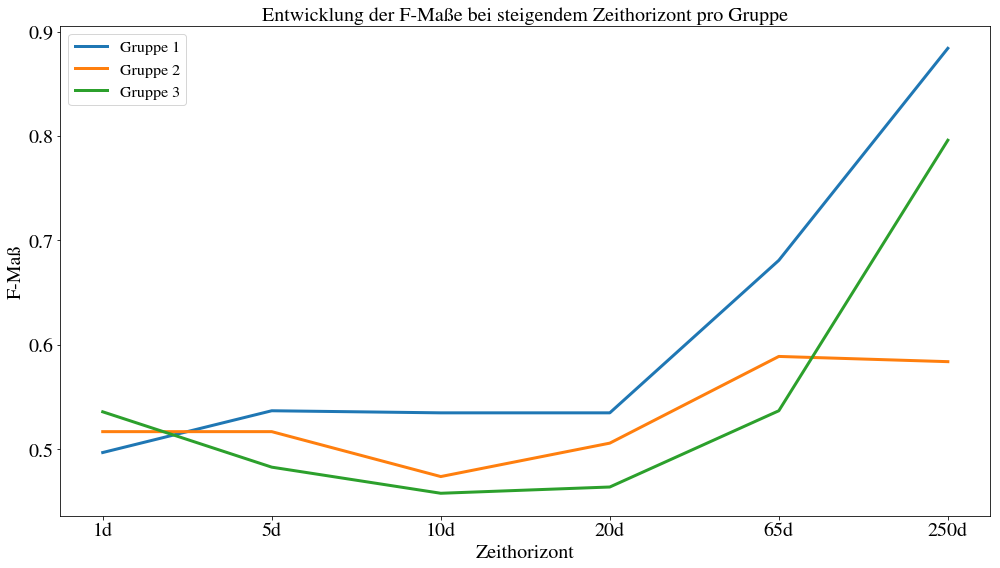

In [13]:
fmeasures_g1 = [0.497, 0.537, 0.535, 0.535, 0.681, 0.884]
fmeasures_g2 = [0.517, 0.517, 0.474, 0.506, 0.589, 0.584]
fmeasures_g3 = [0.536, 0.483, 0.458, 0.464, 0.537, 0.796]
x_values = [0, 1, 2, 3, 4, 5]

plt.plot(x_values, fmeasures_g1, label="Gruppe 1", linewidth=3)
plt.plot(x_values, fmeasures_g2, label="Gruppe 2", linewidth=3)
plt.plot(x_values, fmeasures_g3, label="Gruppe 3", linewidth=3)

# 3. Design diagram incl. legend
plt.xlabel("Zeithorizont")
plt.ylabel("F-Maß")
plt.title("Entwicklung der F-Maße bei steigendem Zeithorizont pro Gruppe")
plt.xticks(x_values, ["1d", "5d", "10d", "20d", "65d", "250d"])
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.legend()
plt.tight_layout()

# plt.savefig("./Plots/FMeasure4ClfsPerGroup.jpeg")

### Plot f-measure TECH_AVG on horizons overview (line chart)

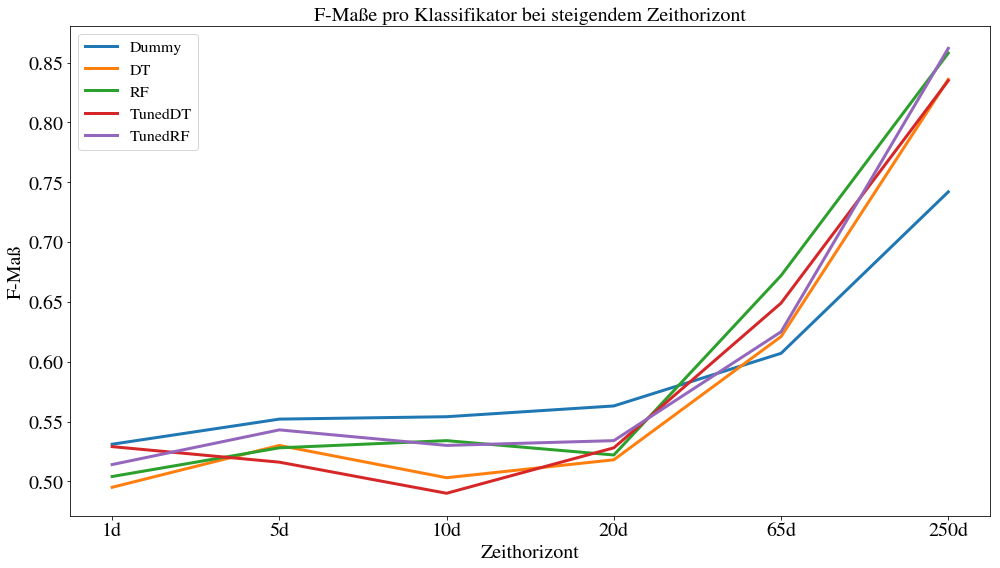

In [17]:
fmeasures_dummy = [0.531, 0.552, 0.554, 0.563, 0.607, 0.742]
fmeasures_dt = [0.495, 0.530, 0.503, 0.518, 0.621, 0.836]
fmeasures_rf = [0.504, 0.528, 0.534, 0.522, 0.672, 0.858]
fmeasures_tuneddt = [0.529, 0.516, 0.490, 0.528, 0.649, 0.835]
fmeasures_tunedrf = [0.514, 0.543, 0.530, 0.534, 0.625, 0.862]
x_values = [0, 1, 2, 3, 4, 5]

plt.plot(x_values, fmeasures_dummy, label="Dummy", linewidth=3)
plt.plot(x_values, fmeasures_dt, label="DT", linewidth=3)
plt.plot(x_values, fmeasures_rf, label="RF", linewidth=3)
plt.plot(x_values, fmeasures_tuneddt, label="TunedDT", linewidth=3)
plt.plot(x_values, fmeasures_tunedrf, label="TunedRF", linewidth=3)

# 3. Design diagram incl. legend
plt.xlabel("Zeithorizont")
plt.ylabel("F-Maß")
plt.title("F-Maße pro Klassifikator bei steigendem Zeithorizont")
plt.xticks(x_values, ["1d", "5d", "10d", "20d", "65d", "250d"])
fig = plt.gcf()
fig.set_size_inches(14, 8)

plt.legend()
plt.tight_layout()

plt.savefig("./Plots/FMeasuresOnHorizons5clf.jpeg")

### Plot stacked bar charts of class distributions (X-axis = e.g. horizons or training epochs)

In [103]:
def plot_stacked_class_distr(ticker, negative_counts, positive_counts):
    x_values = [x for x in range(len(negative_counts))]
    plt.bar(x_values, negative_counts, width=0.7, label="Negativ")
    plt.bar(x_values, positive_counts, width=0.7, bottom=negative_counts, label="Positiv")

    # Design diagram incl. legend
    plt.xlabel("Zeithorizont")
    plt.ylabel("Häufigkeiten")
    plt.title("Klassen-Häufigkeitsverteilung auf " + str(ticker) + " bei steigendem Zeithorizont")
    plt.xticks(x_values, ["1d", "5d", "10d", "20d", "65d", "250d"])
    plt.axhline(y=380,color="gray", ls="--")
    fig = plt.gcf()
    fig.set_size_inches(14, 8)
    plt.ylim([0, 870])
    plt.legend(ncol=2)
    plt.tight_layout()

    plt.savefig("./Plots/Class-Balances-Stacked/StackedClassesBars-" + str(ticker) + ".jpeg")